# 0. Import Libraries

In [10]:
# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# Helper imports
import os 
import warnings
import pandas_datareader as web
import datetime as dt
from tqdm.notebook import tqdm

# ML/DL imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

In [11]:
import tensorflow as tf, numpy as np, pandas as pd, sklearn, statsmodels
print("tf:", tf.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)
print("statsmodels:", statsmodels.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


tf: 2.20.0
numpy: 2.2.6
pandas: 2.3.2
sklearn: 1.7.1
statsmodels: 0.14.5
GPU available: []


In [12]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
print("OK:", TimeseriesGenerator)

OK: <class 'keras.src.legacy.preprocessing.sequence.TimeseriesGenerator'>


In [13]:
import tensorflow as tf

print("TF version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs:", tf.config.list_physical_devices('GPU'))

# Bật memory growth để tránh chiếm trọn VRAM
for g in tf.config.list_physical_devices('GPU'):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("Memory growth not set for", g, "→", e)

# (tuỳ chọn) log device placement để chắc chắn đang chạy trên GPU
# tf.debugging.set_log_device_placement(True)


TF version: 2.20.0
Built with CUDA: True
GPUs: []


In [14]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


In [15]:
# # Chạy 1 tính toán mẫu để xem device
# with tf.device('/GPU:0'):
#     a = tf.random.normal([4096, 4096])
#     b = tf.matmul(a, a)
#     print(b.device)


In [16]:
a = tf.random.normal([4096, 4096])
b = tf.matmul(a, a)
print(b.device)

/job:localhost/replica:0/task:0/device:CPU:0


# 1. EDA

In [17]:
path = '/work/22010742/anhthu/SF/Dataset/'

train_data = pd.read_csv(path+'train.csv', index_col=0)
test_data = pd.read_csv(path+'test.csv', index_col=0)
data_oil = pd.read_csv(path+'oil.csv')
samp_subm = pd.read_csv(path+'sample_submission.csv')
data_holi = pd.read_csv(path+'holidays_events.csv')
data_trans = pd.read_csv(path+'transactions.csv')
data_store =  pd.read_csv(path+'stores.csv')


In [18]:
def basic_eda(df):
    print("-------------------------------TOP 5 RECORDS-----------------------------")
    print(df.head(5))
    print("-------------------------------INFO--------------------------------------")
    print(df.info())
    print("-------------------------------Describe----------------------------------")
    print(df.describe())
    print("-------------------------------Columns-----------------------------------")
    print(df.columns)
    print("-------------------------------Data Types--------------------------------")
    print(df.dtypes)
    print("----------------------------Missing Values-------------------------------")
    print(df.isnull().sum())
    print("--------------------------Shape Of Data---------------------------------")
    print(df.shape)
    print("============================================================================ \n")

In [19]:
#Litle bit of exploration of data

print("=================================Train Data=================================")
basic_eda(train_data)
print("=================================Test data=================================")
basic_eda(test_data)
print("=================================Holidays events=================================")
basic_eda(data_holi)
print("=================================Transactions data=================================")
basic_eda(data_trans)
print("=================================Stores data=================================")
basic_eda(data_store)
print("=================================Oil data=================================")
basic_eda(data_oil)

=================================Train Data=================================
-------------------------------TOP 5 RECORDS-----------------------------
          date  store_nbr      family  sales  onpromotion
id                                                       
0   2013-01-01          1  AUTOMOTIVE    0.0            0
1   2013-01-01          1   BABY CARE    0.0            0
2   2013-01-01          1      BEAUTY    0.0            0
3   2013-01-01          1   BEVERAGES    0.0            0
4   2013-01-01          1       BOOKS    0.0            0
-------------------------------INFO--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 137.4+ MB
None
-----------

## 1.1. Merge data train từ các file

In [20]:
# 1) dtypes
train_data['date']  = pd.to_datetime(train_data['date'])
data_oil['date']    = pd.to_datetime(data_oil['date'])
data_trans['date']  = pd.to_datetime(data_trans['date'])
data_holi['date']   = pd.to_datetime(data_holi['date'])

for df in [train_data, data_trans, data_store]:
    df['store_nbr'] = df['store_nbr'].astype(int)

In [21]:
# # 2) base = train only
# base = train_data[['date','store_nbr','family']].drop_duplicates()

In [22]:
# 3) merge các bảng KHÁC holiday
df_visualization = (train_data
    .merge(data_oil,  on='date', how='left')                    # dcoilwtico: để NaN, xử lý sau
    .merge(data_store, on='store_nbr', how='left')
    .merge(data_trans, on=['date','store_nbr'], how='left')
    .rename(columns={'type':'store_type'})
)

# transactions NaN -> 0
df_visualization['transactions'] = df_visualization['transactions'].fillna(0).astype('int64')

In [23]:
df_visualization[:3]

,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,store_type,cluster,transactions
0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,0
1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,0
2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,0


In [24]:
len(df_visualization)

3000888

In [25]:
# 4) xử lý holiday
# Kiểm tra số event mỗi ngày
count_per_day = data_holi.groupby("date").size().reset_index(name="n_events")

# Lọc ra ngày có nhiều hơn 1 sự kiện
dup_days = count_per_day[count_per_day["n_events"] > 1]

print("Tổng số ngày có nhiều hơn 1 event:", len(dup_days))
print(dup_days.head(10))  # xem thử 10 ngày đầu

Tổng số ngày có nhiều hơn 1 event: 31
         date  n_events
7  2012-06-25         3
8  2012-07-03         2
29 2012-12-22         2
31 2012-12-24         2
34 2012-12-31         2
48 2013-05-12         2
51 2013-06-25         3
52 2013-07-03         2
75 2013-12-22         2
99 2014-06-25         4


In [26]:
# Xem chi tiết các event trong ngày 2012-06-25
data_holi[data_holi["date"] == "2012-06-25"]

,date,type,locale,locale_name,description,transferred
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [27]:
# 4) xử lý holiday
holi = data_holi.copy()
holi['type'] = holi['type'].str.strip().replace({'Transfer':'Holiday'})
if 'transferred' in holi.columns:
    holi = holi[~holi['transferred']]

type_cols = pd.get_dummies(holi['type'], prefix='type', dtype=int)
holi_oh = pd.concat([holi[['date','locale','locale_name']], type_cols], axis=1)

base_types = [c for c in holi_oh.columns if c.startswith('type_')]

holi_nat = (holi_oh[holi_oh['locale']=='National'][['date']+base_types]
            .groupby('date', as_index=False).max(numeric_only=True))

holi_reg = (holi_oh[holi_oh['locale']=='Regional'][['date','locale_name']+base_types]
            .rename(columns={'locale_name':'state'})
            .groupby(['date','state'], as_index=False).max(numeric_only=True))

holi_loc = (holi_oh[holi_oh['locale']=='Local'][['date','locale_name']+base_types]
            .rename(columns={'locale_name':'city'})
            .groupby(['date','city'], as_index=False).max(numeric_only=True))

Xử lý data_holi:


Transfer → Holiday, bỏ transferred==True.


One-hot theo type (động).


Tách theo locale (National/Regional/Local), groupby về 1 dòng/khóa bằng .max().


In [28]:
# 5) merge holiday đúng phạm vi và gộp về một cột/loại
df_visualization = df_visualization.merge(holi_nat, on='date', how='left')
df_visualization = df_visualization.merge(holi_reg, on=['date','state'], how='left',
                                          suffixes=('', '_reg'))
df_visualization = df_visualization.merge(holi_loc, on=['date','city'],  how='left',
                                          suffixes=('', '_loc'))

for b in base_types:
    b_reg, b_loc = f"{b}_reg", f"{b}_loc"
    cols = [c for c in [b, b_reg, b_loc] if c in df_visualization.columns]
    df_visualization[b] = (df_visualization[cols].fillna(0).sum(axis=1)
                           .clip(upper=1).astype(int))
    df_visualization.drop(columns=[c for c in [b_reg, b_loc] if c in df_visualization.columns],
                          inplace=True, errors='ignore')


Merge holiday đúng phạm vi:


National: on='date'


Regional: on=['date','state']


Local: on=['date','city']
 Sau đó cộng (hoặc max) 3 phạm vi vào một cột one-hot/loại, xoá cột tạm.

 Đảm bảo khoá day-store-family của train là unique


In [29]:
len(df_visualization)

3000888

In [30]:
# 6) time features
# Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. 
# Supermarket sales could be affected by this.
# 6) time features
df_visualization['year']        = df_visualization['date'].dt.year
df_visualization['month']       = df_visualization['date'].dt.month
df_visualization['week']        = df_visualization['date'].dt.isocalendar().week
df_visualization['quarter']     = df_visualization['date'].dt.quarter
df_visualization['dow']         = df_visualization['date'].dt.weekday            # 0=Mon..6=Sun
df_visualization['dayofyear']   = df_visualization['date'].dt.dayofyear
df_visualization['is_weekend']  = (df_visualization['dow'] >= 5).astype(int)

# thêm 2 cột theo note
df_visualization['is_15th']     = (df_visualization['date'].dt.day == 15).astype(int)
df_visualization['is_month_end'] = df_visualization['date'].dt.is_month_end.astype(int)



In [31]:
import pandas as pd

pd.set_option('display.max_columns', None)   # Hiện tất cả các cột
pd.set_option('display.width', None)         # Không giới hạn độ rộng
print(df_visualization.head(1))


        date  store_nbr      family  sales  onpromotion  dcoilwtico   city  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0         NaN  Quito   

       state store_type  cluster  transactions  type_Additional  type_Bridge  \
0  Pichincha          D       13             0                0            0   

   type_Event  type_Holiday  type_Work Day  year  month  week  quarter  dow  \
0           0             1              0  2013      1     1        1    1   

   dayofyear  is_weekend  is_15th  is_month_end  
0          1           0        0             0  


In [32]:
df_visualization.isnull().sum()

date                    0
store_nbr               0
family                  0
sales                   0
onpromotion             0
dcoilwtico         928422
city                    0
state                   0
store_type              0
cluster                 0
transactions            0
type_Additional         0
type_Bridge             0
type_Event              0
type_Holiday            0
type_Work Day           0
year                    0
month                   0
week                    0
quarter                 0
dow                     0
dayofyear               0
is_weekend              0
is_15th                 0
is_month_end            0
dtype: int64

In [33]:
# Điền giá trị null bằng giá trị của ngày liền trước
# Vì ffill chỉ điền từ trên xuống, nếu dòng đầu tiên bị null thì nó vẫn giữ nguyên. 
# Bạn có thể kết hợp bfill để lấp bằng ngày liền sau:
df_visualization['dcoilwtico'] = (
    df_visualization['dcoilwtico']
    .fillna(method='ffill')
    .fillna(method='bfill')
)

In [34]:
df_visualization.isnull().sum()

date               0
store_nbr          0
family             0
sales              0
onpromotion        0
dcoilwtico         0
city               0
state              0
store_type         0
cluster            0
transactions       0
type_Additional    0
type_Bridge        0
type_Event         0
type_Holiday       0
type_Work Day      0
year               0
month              0
week               0
quarter            0
dow                0
dayofyear          0
is_weekend         0
is_15th            0
is_month_end       0
dtype: int64

In [35]:
df_visualization.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 25 columns):
 #   Column           Dtype         
---  ------           -----         
 0   date             datetime64[ns]
 1   store_nbr        int64         
 2   family           object        
 3   sales            float64       
 4   onpromotion      int64         
 5   dcoilwtico       float64       
 6   city             object        
 7   state            object        
 8   store_type       object        
 9   cluster          int64         
 10  transactions     int64         
 11  type_Additional  int64         
 12  type_Bridge      int64         
 13  type_Event       int64         
 14  type_Holiday     int64         
 15  type_Work Day    int64         
 16  year             int32         
 17  month            int32         
 18  week             UInt32        
 19  quarter          int32         
 20  dow              int32         
 21  dayofyear        int32         

In [36]:
# AVG sales theo store_type, family, cluster
df_store_sales = df_visualization.groupby('store_type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
df_fam_sales = df_visualization.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:10]
df_clus_sales = df_visualization.groupby('cluster').agg({"sales" : "mean"}).reset_index() 

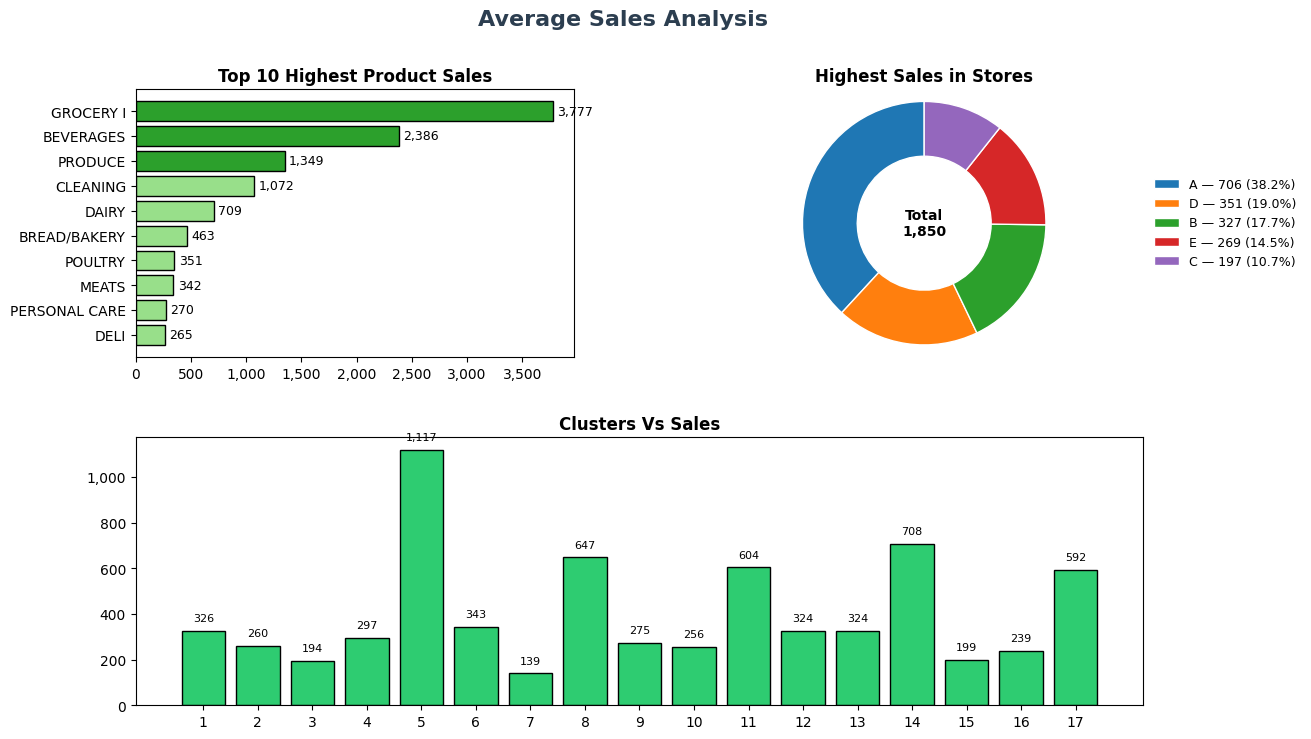

In [37]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
import numpy as np

# Chuẩn hoá tên cột để code vẽ dùng chung 1 tên
df_fam_sales  = df_fam_sales.rename(columns={'sales': 'avg_sales_per_store_per_day'})
df_store_sales = df_store_sales.rename(columns={'sales': 'avg_sales_per_store_per_day'})
df_clus_sales  = df_clus_sales.rename(columns={'sales': 'avg_sales_per_store_per_day'})


# formatter: 1,234
fmt = FuncFormatter(lambda x, pos: f'{x:,.0f}')

fig = plt.figure(figsize=(13, 8))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

# (1) Top 10 Highest Product Sales — barh
ax1 = fig.add_subplot(gs[0, 0])
ax1.barh(df_fam_sales['family'], df_fam_sales['avg_sales_per_store_per_day'],
         color=['#2ca02c' if i < 3 else '#98df8a' for i in range(len(df_fam_sales))],
         edgecolor='black')
ax1.invert_yaxis()
ax1.set_title("Top 10 Highest Product Sales", fontsize=12, weight='bold')
ax1.xaxis.set_major_formatter(fmt)
for ylab, val in zip(df_fam_sales['family'], df_fam_sales['avg_sales_per_store_per_day']):
    ax1.text(val + max(df_fam_sales['avg_sales_per_store_per_day'])*0.01,
             ylab, f'{val:,.0f}', va='center', ha='left', fontsize=9, color='black')

# (2) Highest Sales in Stores — donut with legend
ax2 = fig.add_subplot(gs[0, 1])
tmp = df_store_sales.sort_values('avg_sales_per_store_per_day', ascending=False).copy()
tmp.rename(columns={'avg_sales_per_store_per_day':'sales'}, inplace=True)
vals = tmp['sales'].to_numpy()
labels = tmp['store_type'].astype(str).to_numpy()
colors = plt.get_cmap('tab10').colors[:len(vals)]

wedges, _ = ax2.pie(
    vals, startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.45, edgecolor="white")
)
ax2.set_title("Highest Sales in Stores", fontsize=12, weight='bold')
ax2.axis('equal')

pct = vals / vals.sum() * 100
legend_labels = [f"{l} — {v:,.0f} ({p:.1f}%)" for l, v, p in zip(labels, vals, pct)]
ax2.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, fontsize=9)

ax2.text(0, 0, f"Total\n{vals.sum():,.0f}", ha='center', va='center', fontsize=10, weight='bold')

# (3) Clusters Vs Sales — bar
ax3 = fig.add_subplot(gs[1, :])
x = df_clus_sales['cluster'].to_numpy()
y = df_clus_sales['avg_sales_per_store_per_day'].to_numpy()
ax3.bar(x, y, color='#2ecc71', edgecolor='black')
ax3.set_title("Clusters Vs Sales", fontsize=12, weight='bold')
ax3.set_xticks(x)
ax3.yaxis.set_major_formatter(fmt)
for xi, val in zip(x, y):
    ax3.text(xi, val + max(y)*0.03, f'{val:,.0f}', ha='center', va='bottom', fontsize=8, color='black')

fig.suptitle("Average Sales Analysis", fontsize=16, color='#2c3e50', weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


🎯 Trực quan về biến cần dự đoán (df_fam_sales):
- Trung bình số lượng sản phẩm bán được theo ngày và cửa hàng cho từng nhóm hàng (family).

📊 Phân tích theo store_type (df_store_sales):
- Loại cửa hàng khác nhau có mức doanh số trung bình khác nhau (Ảnh hưởng của store_type)

📊 Phân tích theo cluster (df_clus_sales):
- Các cụm thị trường (cluster) cho thấy sức mua khác nhau (Ảnh hưởng của cluster)

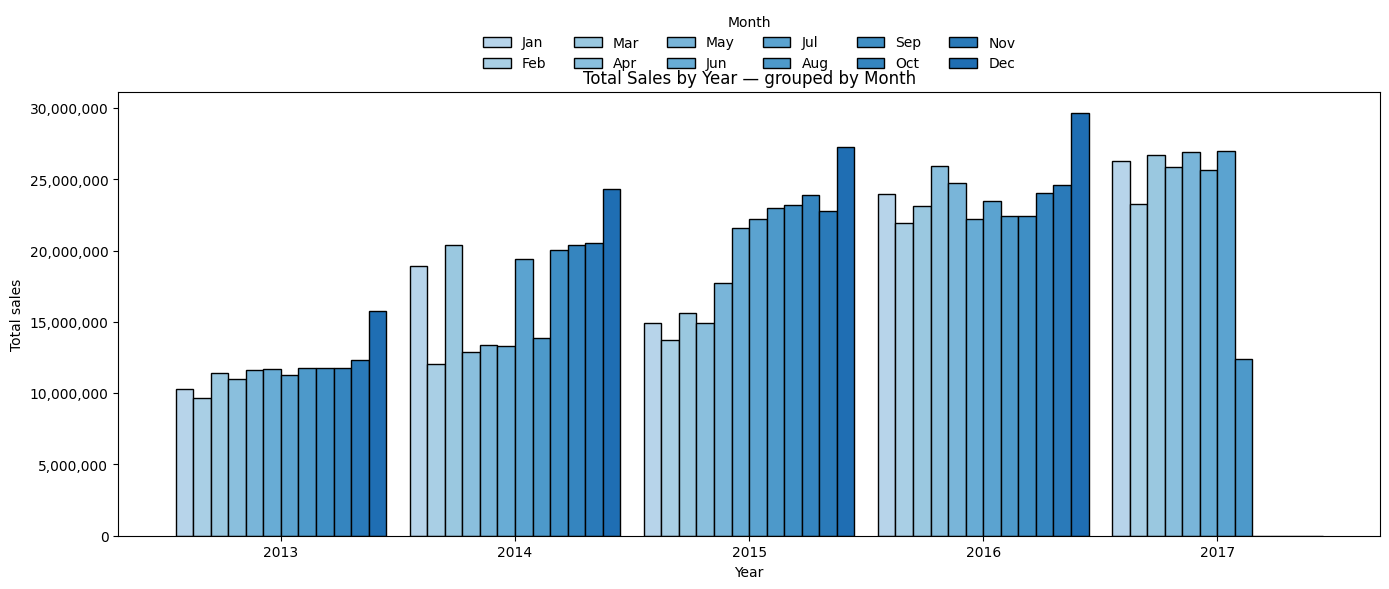

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import calendar

# === 1. Chuẩn bị dữ liệu theo năm-tháng ===
df_year_month = (
    df_visualization
    .assign(year=df_visualization['date'].dt.year,
            month=df_visualization['date'].dt.month)
    .groupby(['year','month'], as_index=False)['sales'].sum()
)

# đảm bảo đủ 12 tháng mỗi năm
years = np.sort(df_year_month['year'].unique())
months = np.arange(1, 13)

full_idx = pd.MultiIndex.from_product([years, months], names=['year','month'])
df_full = (df_year_month.set_index(['year','month'])
           .reindex(full_idx, fill_value=0)
           .reset_index())

# pivot: rows = year, cols = month
pv = df_full.pivot(index='year', columns='month', values='sales')

# === 2. Vẽ grouped bar với cùng 1 tone màu (Blues) ===
fmt = FuncFormatter(lambda x, pos: f'{x:,.0f}')

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(years))
n_m = len(months)
group_w = 0.9
bar_w = group_w / n_m
offsets = -group_w/2 + (np.arange(n_m) + 0.5) * bar_w

cmap = plt.get_cmap("Blues")
colors = [cmap(0.3 + 0.5*j/n_m) for j in range(n_m)]  # từ nhạt tới đậm

for j, m in enumerate(months):
    ax.bar(x + offsets[j],
           pv[m].to_numpy(),
           width=bar_w,
           label=calendar.month_abbr[m],
           color=colors[j],
           edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(years.astype(int))
ax.set_xlabel('Year')
ax.set_ylabel('Total sales')
ax.yaxis.set_major_formatter(fmt)
ax.set_title('Total Sales by Year — grouped by Month')

ax.legend(title='Month', ncol=6, bbox_to_anchor=(0.5, 1.02),
          loc='lower center', frameon=False)

plt.tight_layout()
plt.show()


Cảm quan về ảnh hưởng của thời gian tới sales
- Tăng dần theo năm
- Trong 1 năm thì tăng dần về cuối năm

## 1.2. Kiểm tra phân phối

- Vẽ biểu đồ giá trị theo thời gian (line plot) để quan sát xu hướng (trend) và tính mùa vụ (seasonality).
- Vẽ histogram để kiểm tra phân phối của giá trị numerical
- Phân tích các đặc điểm như tính dừng (stationarity) bằng cách sử dụng kiểm định ADF (Augmented Dickey-Fuller) hoặc vẽ ACF/PACF để kiểm tra tự tương quan.


In [39]:
# # Phân phối của các biến số sales, dcoilwtico, transactions, promotion
# import seaborn as sns
# import matplotlib.pyplot as plt

# cols = ['sales', 'dcoilwtico', 'transactions', 'onpromotion']

# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# for ax, col in zip(axes.flat, cols):
#     sns.histplot(df_visualization[col].dropna(), bins=50, kde=True,
#                  color='#3498db', ax=ax)
#     ax.set_title(f"Distribution of {col}", fontsize=12, weight='bold')
#     ax.set_xlabel(col)
#     ax.set_ylabel("Frequency")

# plt.tight_layout()
# plt.show()



In [40]:
df_visualization[['sales', 'dcoilwtico', 'transactions', 'onpromotion']].describe()


,sales,dcoilwtico,transactions,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,3.577757e+02,6.792490e+01,1.555808e+03,2.602770e+00
std,1.101998e+03,2.566913e+01,1.033367e+03,1.221888e+01
min,0.000000e+00,2.619000e+01,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.637750e+01,9.300000e+02,0.000000e+00
50%,1.100000e+01,5.341000e+01,1.331000e+03,0.000000e+00
75%,1.958473e+02,9.572000e+01,1.976250e+03,0.000000e+00
max,1.247170e+05,1.106200e+02,8.359000e+03,7.410000e+02


3 biến sales, transactions, onpromotion: Phân phối lệch phải cần log transform

RMSLE định nghĩa rõ: dùng log(1+y)
Nên target sales phải biến đổi bằng np.log1p(sales) để nhất quán với loss.


Transactions, onpromotion (features): không bắt buộc, nhưng thường nên dùng log1p thay vì log để an toàn khi có 0

In [41]:
import numpy as np


# log1p cho các biến skew
df_visualization['sales']        = np.log1p(df_visualization['sales'])
df_visualization['transactions'] = np.log1p(df_visualization['transactions'])
df_visualization['onpromotion']  = np.log1p(df_visualization['onpromotion'])

print(df_visualization[['sales','transactions','onpromotion']].describe())


              sales  transactions   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06
mean   2.926368e+00  6.699789e+00  3.761500e-01
std    2.695122e+00  2.061778e+00  9.026737e-01
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    0.000000e+00  6.836259e+00  0.000000e+00
50%    2.484907e+00  7.194437e+00  0.000000e+00
75%    5.282428e+00  7.589462e+00  0.000000e+00
max    1.173381e+01  9.031214e+00  6.609349e+00


In [42]:
# # Phân phối của các biến số sales, dcoilwtico, transactions, promotion sau log1p
# import seaborn as sns
# import matplotlib.pyplot as plt

# cols = ['sales', 'dcoilwtico', 'transactions', 'onpromotion']

# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# for ax, col in zip(axes.flat, cols):
#     sns.histplot(df_visualization[col].dropna(), bins=50, kde=True,
#                  color='#3498db', ax=ax)
#     ax.set_title(f"Distribution of {col}", fontsize=12, weight='bold')
#     ax.set_xlabel(col)
#     ax.set_ylabel("Frequency")

# plt.tight_layout()
# plt.show()


sales: giữ log làm target, không cần scale thêm.

transactions: log1p → phân phối đẹp, scale StandardScaler.

onpromotion: log1p → giảm skew, scale StandardScaler/RobustScaler.

dcoilwtico: không cần log, chỉ scale.

## 1.3. Thêm feature is_earthquake
- Thêm thông tin cho ngày 2016-04-16: trận động đất 7.8 độ Richter ở Ecuador. 
- Trong data, ngày này và một số ngày ngay sau đó có biến động sales và transactions bất thường

In [43]:
# is_earthquake = 1 cho ngày 2016-04-16 và 1 tuần sau đó
start_eq = pd.to_datetime("2016-04-16")
end_eq   = pd.to_datetime("2016-04-22")

df_visualization['is_earthquake'] = (
    (df_visualization['date'] >= start_eq) &
    (df_visualization['date'] <= end_eq)
).astype('int8')

In [44]:
# kiểm tra nhanh
print(df_visualization.loc[
    (df_visualization['date'] >= "2016-04-15") &
    (df_visualization['date'] <= "2016-04-23"),
    ['date','store_nbr','family','sales','is_earthquake']
].head(10))

              date  store_nbr        family     sales  is_earthquake
2133054 2016-04-15          1    AUTOMOTIVE  1.791759              0
2133055 2016-04-15          1     BABY CARE  0.000000              0
2133056 2016-04-15          1        BEAUTY  1.609438              0
2133057 2016-04-15          1     BEVERAGES  7.605890              0
2133058 2016-04-15          1         BOOKS  0.000000              0
2133059 2016-04-15          1  BREAD/BAKERY  5.999472              0
2133060 2016-04-15          1   CELEBRATION  2.639057              0
2133061 2016-04-15          1      CLEANING  6.719013              0
2133062 2016-04-15          1         DAIRY  6.699500              0
2133063 2016-04-15          1          DELI  5.129123              0


## 1.4. Phân tích xu hướng và mùa vụ:


Dùng ACF/PACF để xác định chu kỳ và tự tương quan.


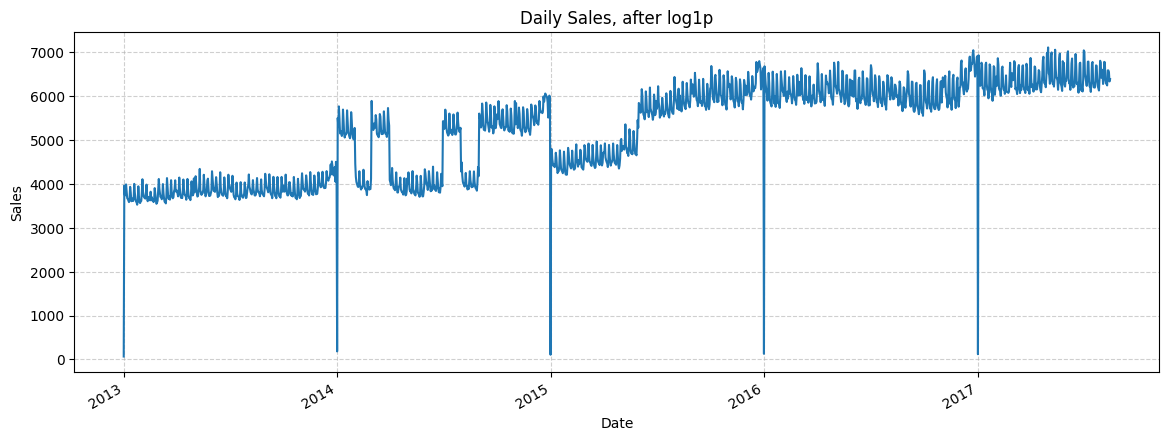

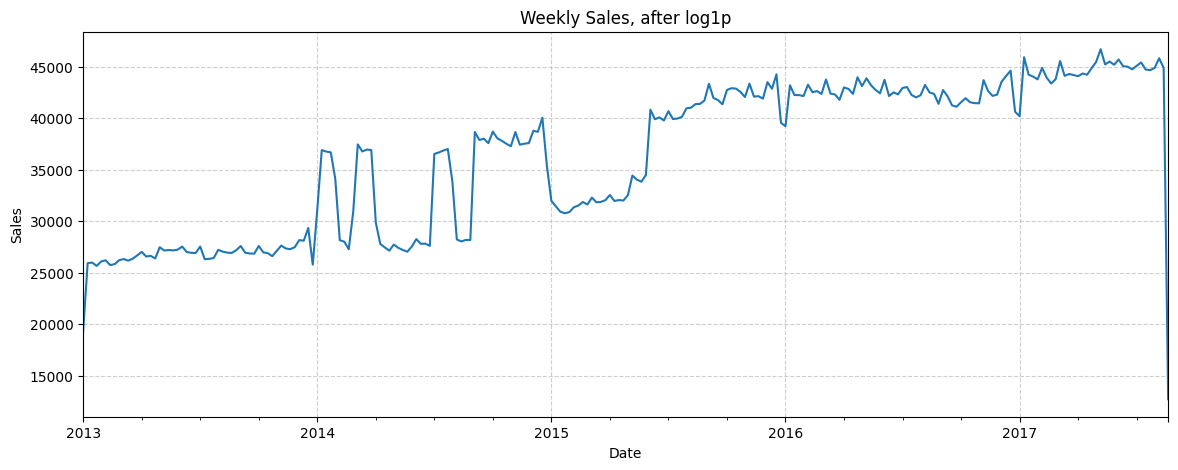

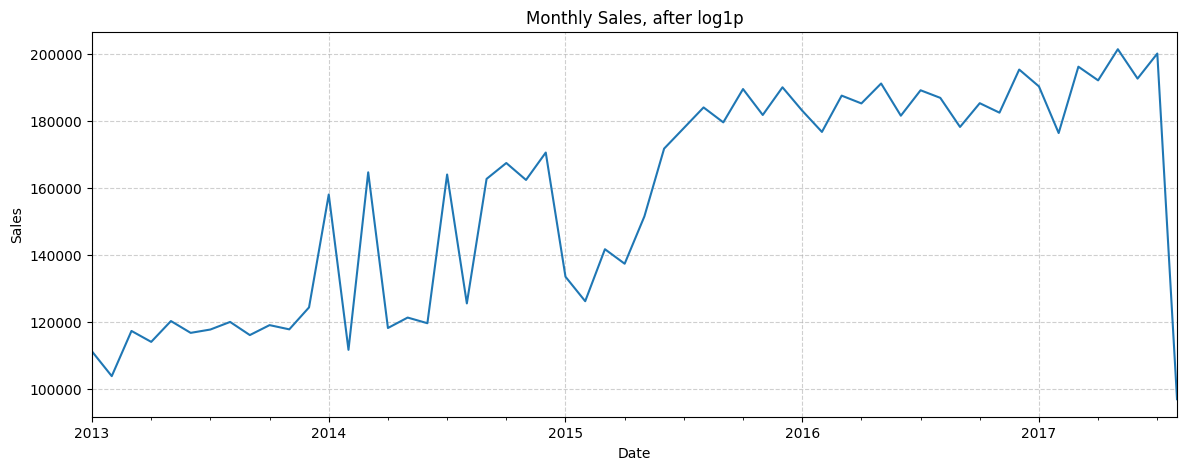

In [45]:
import matplotlib.pyplot as plt


plt.figure(figsize=(14, 5))
daily_sales = df_visualization.groupby('date')['sales'].sum()
daily_sales.plot(title="Daily Sales")
plt.title("Daily Sales, after log1p")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Theo tuần
df_visualization.set_index('date')['sales'].resample('W').sum().plot(figsize=(14,5), title="Weekly Sales, after log1p")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Theo tháng
df_visualization.set_index('date')['sales'].resample('M').sum().plot(figsize=(14,5), title="Monthly Sales, after log1p")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [46]:
import numpy as np
import pandas as pd

# 1) Copy để tránh ghi đè
df_viz_copy = df_visualization.copy()

# 2) Khôi phục sales gốc (vì cột 'sales' đang là log1p)
df_viz_copy['sales_original'] = np.expm1(df_viz_copy['sales'])

# 3) Tổng sales theo ngày (toàn hệ thống)
daily_total = (
    df_viz_copy.groupby('date', as_index=False)['sales_original']
               .sum()
               .rename(columns={'sales_original': 'daily_sales_total'})
)

# 4) Trung bình sales theo ngày (overall)
avg_daily_total = daily_total['daily_sales_total'].mean()

# 5) Lấy 20 ngày có tổng sales thấp nhất (chỉ giữ 2 cột)
lowest_20_days = daily_total.nsmallest(20, 'daily_sales_total')[["date", "daily_sales_total"]]

# In kết quả
print(f"Average daily total sales (original scale): {avg_daily_total:,.2f}")
print("\n20 ngày có tổng sales thấp nhất:")
print(lowest_20_days)


Average daily total sales (original scale): 637,556.38

20 ngày có tổng sales thấp nhất:
           date  daily_sales_total
0    2013-01-01        2511.618999
364  2014-01-01        8602.065404
1457 2017-01-01       12082.500997
728  2015-01-01       12773.616980
1092 2016-01-01       16433.394000
23   2013-01-24      247245.690995
72   2013-03-14      247541.420096
9    2013-01-10      258982.003049
28   2013-01-29      264488.818076
177  2013-06-27      266525.458966
16   2013-01-17      267498.515975
51   2013-02-21      267711.109015
114  2013-04-25      268790.618996
79   2013-03-21      269130.127953
56   2013-02-26      270425.007068
30   2013-01-31      271254.217996
70   2013-03-12      271823.378010
268  2013-09-26      273057.879859
84   2013-03-26      275818.235900
296  2013-10-24      276059.080003


Các ngày đầu năm sales giảm mạnh đột ngột so với trung bình
=> cần tạo biến is_Newyear để model phân biệt tốt|

In [47]:
# Tạo cột is_Newyear: 1 nếu ngày là 1/1, ngược lại 0
df_visualization['is_Newyear'] = (df_visualization['date'].dt.month.eq(1) & 
                                  df_visualization['date'].dt.day.eq(1)).astype(int)

# Kiểm tra nhanh
print(df_visualization[['date','is_Newyear']].drop_duplicates().query("is_Newyear == 1").head())


              date  is_Newyear
0       2013-01-01           1
648648  2014-01-01           1
1297296 2015-01-01           1
1945944 2016-01-01           1
2596374 2017-01-01           1


In [48]:
df_visualization[10000:10003]

,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,store_type,cluster,transactions,type_Additional,type_Bridge,type_Event,type_Holiday,type_Work Day,year,month,week,quarter,dow,dayofyear,is_weekend,is_15th,is_month_end,is_earthquake,is_Newyear
10000,2013-01-06,4,BABY CARE,0.000000,0.0,93.12,Quito,Pichincha,D,9,7.54539,0,0,0,0,0,2013,1,1,1,6,6,1,0,0,0,0
10001,2013-01-06,4,BEAUTY,1.791759,0.0,93.12,Quito,Pichincha,D,9,7.54539,0,0,0,0,0,2013,1,1,1,6,6,1,0,0,0,0
10002,2013-01-06,4,BEVERAGES,7.533694,0.0,93.12,Quito,Pichincha,D,9,7.54539,0,0,0,0,0,2013,1,1,1,6,6,1,0,0,0,0


In [49]:
# import matplotlib.pyplot as plt
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # Vẽ ACF và PACF cho sales
# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plot_acf(df_visualization['sales'], lags=40, ax=axes[0])
# axes[0].set_title("ACF - Autocorrelation Function (sales)")

# plot_pacf(df_visualization['sales'], lags=40, ax=axes[1], method='ywm')
# axes[1].set_title("PACF - Partial Autocorrelation Function (sales)")

# plt.tight_layout()
# plt.show()

In [50]:
# # tự động lấy 200k điểm cuối rồi vẽ ACF/PACF
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # ==== cấu hình nhanh ====
# MAX_N = 200_000      # số điểm tối đa để plot (an toàn cho máy)
# LAGS  = 40           # số lag muốn xem
# RESAMPLE = None      # None hoặc 'D' (ngày), 'W' (tuần), 'M' (tháng)

# # ==== chuẩn bị dữ liệu ====
# dfv = df_visualization.copy()
# dfv['date'] = pd.to_datetime(dfv['date'], errors='coerce')
# ser = dfv.set_index('date')['sales'].sort_index().astype('float').dropna()

# # (tuỳ chọn) resample để giảm nhiễu / giảm số điểm
# if RESAMPLE:
#     # với sales thường hợp lý là sum theo kỳ
#     ser = ser.resample(RESAMPLE).sum().dropna()

# # cắt còn MAX_N điểm cuối nếu quá dài
# n = len(ser)
# if n > MAX_N:
#     ser = ser.iloc[-MAX_N:]
#     print(f"[Info] Chuỗi gốc có {n:,} điểm. Đang dùng {len(ser):,} điểm cuối để plot.")

# # ==== vẽ ACF & PACF ====
# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plot_acf(ser, lags=LAGS, ax=axes[0])                      # ACF → gợi ý MA(q)
# axes[0].set_title(f"ACF (sales) - lags={LAGS}")

# # PACF ổn định với method 'ywm' hoặc 'ywadjusted'
# plot_pacf(ser, lags=LAGS, ax=axes[1], method='ywm')       # PACF → gợi ý AR(p)
# axes[1].set_title(f"PACF (sales) - lags={LAGS}")

# plt.tight_layout()
# plt.show()


- ACF: cut off sau lag = 33 -> chọn làm sequence/lookback
- PACF: lớn ở lag = 7, 33 -> chọn làm lag features

# 2. Train test val split & Tạo Lag của sales

## 2.1. Tạo lag features


In [51]:
import pandas as pd

dfv = df_visualization.copy()
dfv['date'] = pd.to_datetime(dfv['date'], errors='coerce')

# cột định danh series – đổi lại cho đúng tên cột của bạn
GROUP_COLS = ['store_nbr', 'family']      # ví dụ

# sort theo nhóm + thời gian để shift đúng
dfv = dfv.sort_values(GROUP_COLS + ['date']).reset_index(drop=True)

# tạo lag theo từng series
LAGS = [33, 7]   # thêm 18, 24 nếu muốn
for k in LAGS:
    dfv[f'lag_{k}'] = dfv.groupby(GROUP_COLS)['sales'].shift(k)

# bỏ hàng thiếu do lag (bị ở đầu mỗi nhóm)
dfv = dfv.dropna(subset=[f'lag_{k}' for k in LAGS]).reset_index(drop=True)



In [52]:
dfv[-100010:-100000]

,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,store_type,cluster,transactions,type_Additional,type_Bridge,type_Event,type_Holiday,type_Work Day,year,month,week,quarter,dow,dayofyear,is_weekend,is_15th,is_month_end,is_earthquake,is_Newyear,lag_33,lag_7
2842072,2015-01-07,53,BREAD/BAKERY,5.856023,0.693147,48.69,Manta,Manabi,D,13,6.630683,0,0,0,0,0,2015,1,2,1,2,7,0,0,0,0,0,5.645797,6.619760
2842073,2015-01-08,53,BREAD/BAKERY,5.677743,1.386294,48.80,Manta,Manabi,D,13,6.556778,0,0,0,0,0,2015,1,2,1,3,8,0,0,0,0,0,5.823244,0.000000
2842074,2015-01-09,53,BREAD/BAKERY,5.830080,1.609438,48.35,Manta,Manabi,D,13,6.593045,0,0,0,0,0,2015,1,2,1,4,9,0,0,0,0,0,5.738148,6.131885
2842075,2015-01-10,53,BREAD/BAKERY,5.955420,0.693147,48.35,Manta,Manabi,D,13,6.795706,0,0,0,0,1,2015,1,2,1,5,10,1,0,0,0,0,6.182108,6.301395
2842076,2015-01-11,53,BREAD/BAKERY,6.495408,1.386294,48.35,Manta,Manabi,D,13,6.950815,0,0,0,0,0,2015,1,2,1,6,11,1,0,0,0,0,5.781524,6.298125
2842077,2015-01-12,53,BREAD/BAKERY,5.601333,0.000000,46.06,Manta,Manabi,D,13,6.577861,0,0,0,0,0,2015,1,3,1,0,12,0,0,0,0,0,5.395367,5.959398
2842078,2015-01-13,53,BREAD/BAKERY,5.537236,0.693147,45.92,Manta,Manabi,D,13,6.549651,0,0,0,0,0,2015,1,3,1,1,13,0,0,0,0,0,5.454111,6.183233
2842079,2015-01-14,53,BREAD/BAKERY,5.739455,1.098612,48.49,Manta,Manabi,D,13,6.594413,0,0,0,0,0,2015,1,3,1,2,14,0,0,0,0,0,5.564222,5.856023
2842080,2015-01-15,53,BREAD/BAKERY,5.891992,0.693147,46.37,Manta,Manabi,D,13,6.533789,0,0,0,0,0,2015,1,3,1,3,15,0,1,0,0,0,5.606353,5.677743
2842081,2015-01-16,53,BREAD/BAKERY,5.969620,1.791759,48.49,Manta,Manabi,D,13,6.736967,0,0,0,0,0,2015,1,3,1,4,16,0,0,0,0,0,5.912199,5.830080


Tạo lag đúng theo từng store - family

## 2.2. Chia TTV

In [53]:
import numpy as np
import pandas as pd

# 0) Chuẩn bị
dfv['date'] = pd.to_datetime(dfv['date'], errors='coerce')
GROUP_COLS = ['store_nbr', 'family']  # điều chỉnh cho đúng cột nhóm của bạn
dfv = dfv.sort_values(GROUP_COLS + ['date']).reset_index(drop=True)

# 1) Tham số độ dài theo NGÀY (calendar day)
TRAIN_DAYS = 90
VAL_DAYS   = 50
TEST1_DAYS = 40
TEST2_DAYS = 40

# Nếu muốn chỉ LẤY ĐÚNG 90 ngày cho train, đặt False.
# Mặc định True = lấy TẤT CẢ ngày trước mốc val_start vào train (train >= 90)
include_all_prior_as_train = True

def assign_split_by_days(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values('date').copy()
    # các mốc ngày duy nhất
    udates = (
        g['date']
        .dropna()
        .drop_duplicates()
        .sort_values()
        .to_list()
    )
    n_dates = len(udates)
    need = TRAIN_DAYS + VAL_DAYS + TEST1_DAYS + TEST2_DAYS

    # Nếu chuỗi quá ngắn, fallback: ưu tiên test2, test1, val; phần còn lại là train
    if n_dates < need:
        # cắt từ cuối chuỗi về trước theo tỉ lệ yêu cầu
        t2_len = min(TEST2_DAYS, n_dates)
        t2_start_idx = n_dates - t2_len
        t1_end_idx   = t2_start_idx
        t1_len = min(TEST1_DAYS, t1_end_idx)
        t1_start_idx = t1_end_idx - t1_len
        val_end_idx  = t1_start_idx
        v_len = min(VAL_DAYS, val_end_idx)
        v_start_idx = val_end_idx - v_len
        # train = phần còn lại
        tr_start_idx = 0
        tr_end_idx   = v_start_idx

        t2_dates = set(udates[t2_start_idx : n_dates])
        t1_dates = set(udates[t1_start_idx : t1_end_idx])
        v_dates  = set(udates[v_start_idx  : val_end_idx])
        tr_dates = set(udates[tr_start_idx : tr_end_idx])

    else:
        # Lấy đúng các cửa sổ từ CUỐI chuỗi
        # test2: 40 ngày cuối
        t2_start_idx = n_dates - TEST2_DAYS
        t2_end_idx   = n_dates
        # test1: 40 ngày trước test2
        t1_end_idx   = t2_start_idx
        t1_start_idx = t1_end_idx - TEST1_DAYS
        # val: 50 ngày trước test1
        val_end_idx  = t1_start_idx
        val_start_idx= val_end_idx - VAL_DAYS
        # train:
        if include_all_prior_as_train:
            tr_start_idx = 0
        else:
            tr_start_idx = max(0, val_start_idx - TRAIN_DAYS)
        tr_end_idx = val_start_idx

        t2_dates = set(udates[t2_start_idx : t2_end_idx])
        t1_dates = set(udates[t1_start_idx : t1_end_idx])
        v_dates  = set(udates[val_start_idx: val_end_idx])
        tr_dates = set(udates[tr_start_idx : tr_end_idx])

    # gán nhãn theo date
    conds = [
        g['date'].isin(tr_dates),
        g['date'].isin(v_dates),
        g['date'].isin(t1_dates),
        g['date'].isin(t2_dates),
    ]
    choices = ['train', 'val', 'test1', 'test2']
    g['split'] = np.select(conds, choices, default='ignore')

    return g

# 2) Áp dụng theo từng chuỗi
dfv = dfv.groupby(GROUP_COLS, group_keys=False).apply(assign_split_by_days)

# 3) Lấy ra các tập
train_df = dfv[dfv['split'] == 'train'].copy()
val_df   = dfv[dfv['split'] == 'val'].copy()
test1_df = dfv[dfv['split'] == 'test1'].copy()
test2_df = dfv[dfv['split'] == 'test2'].copy()

print("Shapes:", train_df.shape, val_df.shape, test1_df.shape, test2_df.shape)

# 4) Kiểm tra min/max date theo từng split (toàn cục)
def show_range(name, d):
    if d.shape[0] == 0:
        print(f"{name:>6}: empty")
    else:
        print(f"{name:>6}: {pd.to_datetime(d['date']).min().date()}  →  {pd.to_datetime(d['date']).max().date()}  (rows={len(d)})")


show_range("train", train_df)
show_range("val",   val_df)
show_range("test1", test1_df)
show_range("test2", test2_df)


Shapes: (2710422, 30) (89100, 30) (71280, 30) (71280, 30)
 train: 2013-02-03  →  2017-04-07  (rows=2710422)
   val: 2017-04-08  →  2017-05-27  (rows=89100)
 test1: 2017-05-28  →  2017-07-06  (rows=71280)
 test2: 2017-07-07  →  2017-08-15  (rows=71280)


- cắt theo từng chuỗi store_nbr–family, giữ đúng trật tự thời gian: 90% đầu = train, 50 ngày tiếp = val, 40 ngày tiếp = test1, test2 - mục đích retrain lại model theo dữ liệu chuỗi thời gian

In [54]:
# ví dụ chọn 2 chuỗi bất kỳ để kiểm tra
examples = [
    (1, 'BEVERAGES'),
    (2, 'BREAD/BAKERY')   # bạn có thể đổi sang family khác trong dataset của bạn
]

SPLIT_ORDER = ['train', 'val', 'test1', 'test2']

for store, fam in examples:
    ex = dfv[(dfv['store_nbr'] == store) & (dfv['family'] == fam)].copy()
    ex['date'] = pd.to_datetime(ex['date'])
    ex['split'] = pd.Categorical(ex['split'], categories=SPLIT_ORDER, ordered=True)

    stats = (
        ex.groupby('split', observed=True)['date']
          .agg(min_date='min', max_date='max', row_count='count')
          .reset_index()
          .sort_values('split')
    )
    stats['unique_days'] = ex.groupby('split', observed=True)['date'].nunique().values

    print(f"\n=== Store {store} - Family {fam} ===")
    print(stats)



=== Store 1 - Family BEVERAGES ===
   split   min_date   max_date  row_count  unique_days
0  train 2013-02-03 2017-04-07       1521         1521
1    val 2017-04-08 2017-05-27         50           50
2  test1 2017-05-28 2017-07-06         40           40
3  test2 2017-07-07 2017-08-15         40           40

=== Store 2 - Family BREAD/BAKERY ===
   split   min_date   max_date  row_count  unique_days
0  train 2013-02-03 2017-04-07       1521         1521
1    val 2017-04-08 2017-05-27         50           50
2  test1 2017-05-28 2017-07-06         40           40
3  test2 2017-07-07 2017-08-15         40           40


In [55]:
# Drop cột 'split' khỏi các tập 
train_df = train_df.drop(columns=['split'])
val_df   = val_df.drop(columns=['split'])
test1_df = test1_df.drop(columns=['split'])
test2_df = test2_df.drop(columns=['split'])


# 3. Preprocessing

Cần lưu lại pipeline fit_transform train để áp dụng cho tập val test

In [56]:
# Loại bỏ cột target trước khi phân loại features
target = 'sales'

# tất cả cột trừ target
features = [c for c in train_df.columns if c != target]

# categorical = object/string hoặc category dtype
cat_features = train_df[features].select_dtypes(include=['object', 'category']).columns.tolist()

# numerical = number dtype (int, float)
num_features = train_df[features].select_dtypes(include=['number']).columns.tolist()

print("Categorical features:", cat_features)
print("Numerical features:", num_features)
# number of cat & num
print(len(cat_features), len(num_features))

Categorical features: ['family', 'city', 'state', 'store_type']
Numerical features: ['store_nbr', 'onpromotion', 'dcoilwtico', 'cluster', 'transactions', 'type_Additional', 'type_Bridge', 'type_Event', 'type_Holiday', 'type_Work Day', 'year', 'month', 'week', 'quarter', 'dow', 'dayofyear', 'is_weekend', 'is_15th', 'is_month_end', 'is_earthquake', 'is_Newyear', 'lag_33', 'lag_7']
4 23


Đổi store_nbr, cluster thành categorical

Embedding (static covariates): 
- C1: family, store_nbr, city, state, store_type, cluster (nếu là ID).
- C2: embed family, store_nbr, city, state; PCA store_nbr, store_type, cluster -> 1 biến numerical (BỎ TRONG BÀI NỘP)

One-hot/binary giữ nguyên: is_weekend, is_15th, is_month_end, các event types, is_earthquake

Scaled numerical: onpromotion, transactions, dcoilwtico, lag_33, lag_7

Cyclical encode: month, week, dow, dayofyear, quarter; year thì k cần cyclical encode

Drop: date (đã drop ở trước)

In [57]:
train_df[cat_features].head()

,family,city,state,store_type
0,AUTOMOTIVE,Quito,Pichincha,D
1,AUTOMOTIVE,Quito,Pichincha,D
2,AUTOMOTIVE,Quito,Pichincha,D
3,AUTOMOTIVE,Quito,Pichincha,D
4,AUTOMOTIVE,Quito,Pichincha,D


In [58]:
train_df[num_features].head()

,store_nbr,onpromotion,dcoilwtico,cluster,transactions,type_Additional,type_Bridge,type_Event,type_Holiday,type_Work Day,year,month,week,quarter,dow,dayofyear,is_weekend,is_15th,is_month_end,is_earthquake,is_Newyear,lag_33,lag_7
0,1,0.0,97.46,13,6.276643,0,0,0,0,0,2013,2,5,1,6,34,1,0,0,0,0,0.000000,1.098612
1,1,0.0,96.21,13,7.447168,0,0,0,0,0,2013,2,6,1,0,35,0,0,0,0,0,1.098612,1.386294
2,1,0.0,96.68,13,7.482119,0,0,0,0,0,2013,2,6,1,1,36,0,0,0,0,0,1.386294,1.098612
3,1,0.0,96.44,13,7.525101,0,0,0,0,0,2013,2,6,1,2,37,0,0,0,0,0,1.386294,1.945910
4,1,0.0,95.84,13,7.454720,0,0,0,0,0,2013,2,6,1,3,38,0,0,0,0,0,1.791759,0.000000


- Đổi store_nbr, cluster thành categorical


In [59]:
train_df = train_df.copy()
train_df['store_nbr'] = train_df['store_nbr'].astype('category')
train_df['cluster']   = train_df['cluster'].astype('category')

print(train_df.dtypes[['store_nbr','cluster']])


store_nbr    category
cluster      category
dtype: object


-Train: 
- Cyclical encode: month, week, dow, dayofyear, quarter
- year thì k cần cyclical encode


In [60]:
import numpy as np

train_df = train_df.copy()

# hàm encode tuần hoàn
def cyclical_encode(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

# encode cho các biến tuần hoàn
train_df = cyclical_encode(train_df, 'month', 12)
train_df = cyclical_encode(train_df, 'week', 52)        # ISO weeks
train_df = cyclical_encode(train_df, 'dow', 7)          # day of week
train_df = cyclical_encode(train_df, 'dayofyear', 365)  # day of year
train_df = cyclical_encode(train_df, 'quarter', 4)

# drop các cột gốc (trừ year giữ nguyên)
train_df = train_df.drop(columns=['month','week','dow','dayofyear','quarter'])


Tương tự cho val, test
- Đổi store_nbr, cluster thành categorical
- Cyclical encode: month, week, dow, dayofyear, quarter, year thì k cần cyclical encode


In [61]:
import numpy as np
import pandas as pd

# copy lại để tránh sửa nhầm
val_df   = val_df.copy()
test1_df = test1_df.copy()
test2_df = test2_df.copy()

# ==== 1) Ép dtype categorical cho cluster & store_nbr (val/test1/test2) ====
cat_cols = ['store_nbr', 'cluster']

# (khuyến nghị) nếu có train_df, đồng bộ category theo train để tránh unseen codes
def to_category(df, cols, ref_df=None):
    for c in cols:
        df[c] = df[c].astype('category')
        if ref_df is not None and c in ref_df.columns:
            df[c] = df[c].cat.set_categories(pd.Categorical(ref_df[c]).categories)
    return df

# nếu muốn đồng bộ với train: to_category(val_df, cat_cols, ref_df=train_df) ...
val_df   = to_category(val_df,   cat_cols)  # hoặc truyền ref_df=train_df nếu có
test1_df = to_category(test1_df, cat_cols)  # hoặc truyền ref_df=train_df nếu có
test2_df = to_category(test2_df, cat_cols)  # hoặc truyền ref_df=train_df nếu có


# ==== 2) Cyclical encode cho các biến tuần hoàn ở val/test1/test2 ====
def cyclical_encode(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

# nếu bạn dùng isocalendar().week thì có thể có 53; dayofyear có thể 366 (năm nhuận)
cyc_features = {
    'month': 12,
    'week':  53,   # dùng 53 an toàn cho ISO week
    'dow':   7,
    'dayofyear': 366,  # an toàn cho năm nhuận
    'quarter': 4
}

for col, max_val in cyc_features.items():
    val_df   = cyclical_encode(val_df,   col, max_val)
    test1_df = cyclical_encode(test1_df, col, max_val)
    test2_df = cyclical_encode(test2_df, col, max_val)

# Drop cột gốc cyclical (giữ year)
drop_cols = list(cyc_features.keys())
val_df   = val_df.drop(columns=drop_cols)
test1_df = test1_df.drop(columns=drop_cols)
test2_df = test2_df.drop(columns=drop_cols)



In [62]:
target = 'sales'

def list_features(df, target='sales'):
    # bỏ target ra khỏi tập features
    features = [c for c in df.columns if c != target]
    
    cat_features = df[features].select_dtypes(include=['object','category']).columns.tolist()
    num_features = df[features].select_dtypes(include=['number']).columns.tolist()
    
    return cat_features, num_features

# Train
cat_features, num_features = list_features(train_df, target)
print("Train Categorical:", cat_features)
print("Train Numerical  :", num_features[:20], "... (total:", len(num_features), ")")
print("=> counts:", len(cat_features), len(num_features))

# Val
cat_features, num_features = list_features(val_df, target)
print("\nVal Categorical:", cat_features)
print("Val Numerical  :", num_features[:20], "... (total:", len(num_features), ")")
print("=> counts:", len(cat_features), len(num_features))

# Test1
cat_features, num_features = list_features(test1_df, target)
print("\nTest1 Categorical:", cat_features)
print("Test1 Numerical  :", num_features[:20], "... (total:", len(num_features), ")")
print("=> counts:", len(cat_features), len(num_features))

# Test2
cat_features, num_features = list_features(test2_df, target)
print("\nTest2 Categorical:", cat_features)
print("Test2 Numerical  :", num_features[:20], "... (total:", len(num_features), ")")
print("=> counts:", len(cat_features), len(num_features))


Train Categorical: ['store_nbr', 'family', 'city', 'state', 'store_type', 'cluster']
Train Numerical  : ['onpromotion', 'dcoilwtico', 'transactions', 'type_Additional', 'type_Bridge', 'type_Event', 'type_Holiday', 'type_Work Day', 'year', 'is_weekend', 'is_15th', 'is_month_end', 'is_earthquake', 'is_Newyear', 'lag_33', 'lag_7', 'month_sin', 'month_cos', 'week_sin', 'week_cos'] ... (total: 26 )
=> counts: 6 26

Val Categorical: ['store_nbr', 'family', 'city', 'state', 'store_type', 'cluster']
Val Numerical  : ['onpromotion', 'dcoilwtico', 'transactions', 'type_Additional', 'type_Bridge', 'type_Event', 'type_Holiday', 'type_Work Day', 'year', 'is_weekend', 'is_15th', 'is_month_end', 'is_earthquake', 'is_Newyear', 'lag_33', 'lag_7', 'month_sin', 'month_cos', 'week_sin', 'week_cos'] ... (total: 26 )
=> counts: 6 26

Test1 Categorical: ['store_nbr', 'family', 'city', 'state', 'store_type', 'cluster']
Test1 Numerical  : ['onpromotion', 'dcoilwtico', 'transactions', 'type_Additional', 'type_B

## 3.1. Biến category

### 3.1.1. Encode

Khi bạn định dùng embedding cho các biến categorical (store_nbr, family, city, state, store_type, cluster), thì có vài yêu cầu quan trọng:
- Các biến này phải là discrete IDs (mã rời rạc).

- Thường là integer không âm (0, 1, 2, …, N-1).

- Không được chuẩn hoá (MinMax/StandardScaler) vì embedding lookup chỉ làm việc với index.

In [63]:
train_df[cat_features].head()

,store_nbr,family,city,state,store_type,cluster
0,1,AUTOMOTIVE,Quito,Pichincha,D,13
1,1,AUTOMOTIVE,Quito,Pichincha,D,13
2,1,AUTOMOTIVE,Quito,Pichincha,D,13
3,1,AUTOMOTIVE,Quito,Pichincha,D,13
4,1,AUTOMOTIVE,Quito,Pichincha,D,13


1- Encode train + lưu từng encoder

In [64]:
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd, joblib

cat_features = ['store_nbr','family','city','state','store_type','cluster']

train_df = train_df.copy()

ord_encoders = {}
embed_dims   = {}

for col in cat_features:
    enc = OrdinalEncoder()
    enc.fit(train_df[[col]])
    train_df[f'{col}_idx'] = enc.transform(train_df[[col]]).astype('int32')
    
    ord_encoders[col] = enc
    embed_dims[col]   = int(len(enc.categories_[0]))

# drop cột gốc
train_df.drop(columns=cat_features, inplace=True)

# lưu encoder để dùng cho val/test
joblib.dump({'ord_encoders': ord_encoders, 'embed_dims': embed_dims},
            'ord_encoders_bundle.joblib')


print("Embedding input_dim:", embed_dims)


Embedding input_dim: {'store_nbr': 54, 'family': 33, 'city': 22, 'state': 16, 'store_type': 5, 'cluster': 17}


In [65]:
# Loại bỏ cột target trước khi phân loại features
target = 'sales'

# tất cả cột trừ target
features = [c for c in train_df.columns if c != target]

# categorical = object/string hoặc category dtype
cat_features = train_df[features].select_dtypes(include=['object', 'category']).columns.tolist()

# numerical = number dtype (int, float)
num_features = train_df[features].select_dtypes(include=['number']).columns.tolist()

print("Categorical features:", cat_features)
print("Numerical features:", num_features)
# number of cat & num
print(len(cat_features), len(num_features))

Categorical features: []
Numerical features: ['onpromotion', 'dcoilwtico', 'transactions', 'type_Additional', 'type_Bridge', 'type_Event', 'type_Holiday', 'type_Work Day', 'year', 'is_weekend', 'is_15th', 'is_month_end', 'is_earthquake', 'is_Newyear', 'lag_33', 'lag_7', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'dow_sin', 'dow_cos', 'dayofyear_sin', 'dayofyear_cos', 'quarter_sin', 'quarter_cos', 'store_nbr_idx', 'family_idx', 'city_idx', 'state_idx', 'store_type_idx', 'cluster_idx']
0 32


In [66]:
# IN RA CÁC CỘT ĐÃ ENCODE XONG

train_df.iloc[:5, -5:]

,family_idx,city_idx,state_idx,store_type_idx,cluster_idx
0,0,18,12,3,12
1,0,18,12,3,12
2,0,18,12,3,12
3,0,18,12,3,12
4,0,18,12,3,12


2- Encode val bằng encoder đã lưu

In [67]:
import joblib
val_df = val_df.copy()

# load encoders đã fit từ train
bundle = joblib.load('ord_encoders_bundle.joblib')
ord_encoders = bundle['ord_encoders']

# danh sách cột gốc categorical đã fit encoder
orig_cat_features = ['store_nbr','family','city','state','store_type','cluster']

# encode categorical features (dùng encoder đã fit từ train)
for col in orig_cat_features:
    enc = ord_encoders[col]
    val_df[f'{col}_idx'] = enc.transform(val_df[[col]]).astype('int32')

# drop cột gốc
val_df.drop(columns=orig_cat_features, inplace=True)


3- Encode test bằng encoder đã lưu

In [68]:
# danh sách cột gốc categorical đã fit encoder
orig_cat_features = ['store_nbr','family','city','state','store_type','cluster']

# copy để tránh sửa nhầm
test1_df = test1_df.copy()
test2_df = test2_df.copy()

# encode categorical features (dùng encoder đã fit từ train)
for col in orig_cat_features:
    enc = ord_encoders[col]
    test1_df[f'{col}_idx'] = enc.transform(test1_df[[col]]).astype('int32')
    test2_df[f'{col}_idx'] = enc.transform(test2_df[[col]]).astype('int32')

# drop cột gốc
test1_df.drop(columns=orig_cat_features, inplace=True)
test2_df.drop(columns=orig_cat_features, inplace=True)


In [69]:
train_df.head()

,date,sales,onpromotion,dcoilwtico,transactions,type_Additional,type_Bridge,type_Event,type_Holiday,type_Work Day,year,is_weekend,is_15th,is_month_end,is_earthquake,is_Newyear,lag_33,lag_7,month_sin,month_cos,week_sin,week_cos,dow_sin,dow_cos,dayofyear_sin,dayofyear_cos,quarter_sin,quarter_cos,store_nbr_idx,family_idx,city_idx,state_idx,store_type_idx,cluster_idx
0,2013-02-03,0.000000,0.0,97.46,6.276643,0,0,0,0,0,2013,1,0,0,0,0,0.000000,1.098612,0.866025,0.5,0.568065,0.822984,-0.781831,0.623490,0.552435,0.833556,1.0,6.123234e-17,0,0,18,12,3,12
1,2013-02-04,1.791759,0.0,96.21,7.447168,0,0,0,0,0,2013,0,0,0,0,0,1.098612,1.386294,0.866025,0.5,0.663123,0.748511,0.000000,1.000000,0.566702,0.823923,1.0,6.123234e-17,0,0,18,12,3,12
2,2013-02-05,0.000000,0.0,96.68,7.482119,0,0,0,0,0,2013,0,0,0,0,0,1.386294,1.098612,0.866025,0.5,0.663123,0.748511,0.781831,0.623490,0.580800,0.814046,1.0,6.123234e-17,0,0,18,12,3,12
3,2013-02-06,0.693147,0.0,96.44,7.525101,0,0,0,0,0,2013,0,0,0,0,0,1.386294,1.945910,0.866025,0.5,0.663123,0.748511,0.974928,-0.222521,0.594727,0.803928,1.0,6.123234e-17,0,0,18,12,3,12
4,2013-02-07,0.693147,0.0,95.84,7.454720,0,0,0,0,0,2013,0,0,0,0,0,1.791759,0.000000,0.866025,0.5,0.663123,0.748511,0.433884,-0.900969,0.608477,0.793572,1.0,6.123234e-17,0,0,18,12,3,12


In [70]:
test1_df.head()

,date,sales,onpromotion,dcoilwtico,transactions,type_Additional,type_Bridge,type_Event,type_Holiday,type_Work Day,year,is_weekend,is_15th,is_month_end,is_earthquake,is_Newyear,lag_33,lag_7,month_sin,month_cos,week_sin,week_cos,dow_sin,dow_cos,dayofyear_sin,dayofyear_cos,quarter_sin,quarter_cos,store_nbr_idx,family_idx,city_idx,state_idx,store_type_idx,cluster_idx
1571,2017-05-28,1.098612,0.0,49.58,6.240276,0,0,0,0,0,2017,1,0,0,0,0,1.386294,0.693147,5.000000e-01,-0.866025,0.6068,-0.794854,-0.781831,0.623490,0.565345,-0.824855,1.224647e-16,-1.0,0,0,18,12,3,12
1572,2017-05-29,1.945910,0.0,49.58,7.467942,0,0,0,0,0,2017,0,0,0,0,0,1.098612,1.098612,5.000000e-01,-0.866025,0.508531,-0.861044,0.000000,1.000000,0.551102,-0.834438,1.224647e-16,-1.0,0,0,18,12,3,12
1573,2017-05-30,1.098612,0.0,49.63,7.479300,0,0,0,0,0,2017,0,0,0,0,0,2.197225,1.609438,5.000000e-01,-0.866025,0.508531,-0.861044,0.781831,0.623490,0.536696,-0.843776,1.224647e-16,-1.0,0,0,18,12,3,12
1574,2017-05-31,1.386294,0.0,48.29,7.538495,0,0,0,0,0,2017,0,0,1,0,0,1.386294,2.079442,5.000000e-01,-0.866025,0.508531,-0.861044,0.974928,-0.222521,0.522133,-0.852864,1.224647e-16,-1.0,0,0,18,12,3,12
1575,2017-06-01,1.945910,0.0,48.32,7.504392,0,0,0,0,0,2017,0,0,0,0,0,1.098612,1.098612,1.224647e-16,-1.000000,0.508531,-0.861044,0.433884,-0.900969,0.507415,-0.861702,1.224647e-16,-1.0,0,0,18,12,3,12


In [71]:
col = "family"
enc = ord_encoders[col]

print(f"=== Full encode/decode mapping for '{col}' ===")

# --- Train ---
train_map = (
    train_df.groupby(f"{col}_idx")
            .size()
            .reset_index(name="count")
)
train_map["decode"] = enc.inverse_transform(train_map[[f"{col}_idx"]]).ravel()
print("\nTrain mapping:")
print(train_map.head(20))  # hoặc bỏ head() để in hết

# --- Test1 ---
test1_map = (
    test1_df.groupby(f"{col}_idx")
            .size()
            .reset_index(name="count")
)
test1_map["decode"] = enc.inverse_transform(test1_map[[f"{col}_idx"]]).ravel()
print("\nTest1 mapping:")
print(test1_map.head(20))


=== Full encode/decode mapping for 'family' ===

Train mapping:
    family_idx  count               decode
0            0  82134           AUTOMOTIVE
1            1  82134            BABY CARE
2            2  82134               BEAUTY
3            3  82134            BEVERAGES
4            4  82134                BOOKS
5            5  82134         BREAD/BAKERY
6            6  82134          CELEBRATION
7            7  82134             CLEANING
8            8  82134                DAIRY
9            9  82134                 DELI
10          10  82134                 EGGS
11          11  82134         FROZEN FOODS
12          12  82134            GROCERY I
13          13  82134           GROCERY II
14          14  82134             HARDWARE
15          15  82134   HOME AND KITCHEN I
16          16  82134  HOME AND KITCHEN II
17          17  82134      HOME APPLIANCES
18          18  82134            HOME CARE
19          19  82134           LADIESWEAR

Test1 mapping:
    family_idx  c

## 3.2. Biến numerical

- Kiểm tra phân phối trc khi Scale

In [72]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# features_to_check = ['onpromotion', 'transactions', 'dcoilwtico', 'lag_33', 'lag_7']

# # copy và gắn nhãn dataset
# train_tmp  = train_df.copy();  train_tmp['dataset']  = 'train'
# val_tmp    = val_df.copy();    val_tmp['dataset']    = 'val'
# test1_tmp  = test1_df.copy();  test1_tmp['dataset']  = 'test1'
# test2_tmp  = test2_df.copy();  test2_tmp['dataset']  = 'test2'

# # gộp lại
# df_check = pd.concat([
#     train_tmp[features_to_check + ['dataset']],
#     val_tmp[features_to_check + ['dataset']],
#     test1_tmp[features_to_check + ['dataset']],
#     test2_tmp[features_to_check + ['dataset']]
# ])

# # vẽ histogram cho từng feature
# for col in features_to_check:
#     plt.figure(figsize=(8,4))
#     sns.histplot(data=df_check, x=col, hue='dataset',
#                  element="step", stat="density", common_norm=False)
#     plt.title(f"Distribution of {col} across train/val/test1/test2")
#     plt.show()


- Phân phối Train-Val-Test của các biến đều hợp lệ để Standard Scaler

### 3.2.1. Normalize/scale


- Biến target: sales
- Không nên Scale để còn predict

- Biến year, onpromotion, transactions, dcoilwtico, lag_33, lag_7: chưa scale

In [73]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# 0) Cấu hình
scale_cols = ['year', 'onpromotion', 'transactions', 'dcoilwtico', 'lag_33', 'lag_7']

# Bảo toàn bản gốc nếu cần
train_df  = train_df.copy()
val_df    = val_df.copy()
test1_df  = test1_df.copy()
test2_df  = test2_df.copy()

# 1) Fit scaler trên TRAIN
scaler = StandardScaler()
scaler.fit(train_df[scale_cols])


,copy,True
,with_mean,True
,with_std,True


In [74]:
# 2) Transform TRAIN/VAL/TEST1/TEST2
def add_scaled_and_drop(df, cols, scaler, suffix='_sc'):
    Xs = scaler.transform(df[cols])
    Xs = pd.DataFrame(Xs, columns=[c+suffix for c in cols], index=df.index)
    out = pd.concat([df.drop(columns=cols), Xs], axis=1)
    return out

train_df  = add_scaled_and_drop(train_df,  scale_cols, scaler)
val_df    = add_scaled_and_drop(val_df,    scale_cols, scaler)
test1_df  = add_scaled_and_drop(test1_df,  scale_cols, scaler)
test2_df  = add_scaled_and_drop(test2_df,  scale_cols, scaler)


In [75]:
# 3) Kiểm tra lại
sc_cols_sc = [c + '_sc' for c in scale_cols]

print("Scaled columns added:", sc_cols_sc)
print("Shapes:",
      "train", train_df.shape,
      "val",   val_df.shape,
      "test1", test1_df.shape,
      "test2", test2_df.shape)

# Kiểm tra mean≈0, std≈1 trên TRAIN cho các cột đã scale
print("\nTRAIN scaled means (≈0):")
print(train_df[sc_cols_sc].mean().round(4))
print("\nTRAIN scaled stds (≈1):")
print(train_df[sc_cols_sc].std(ddof=0).round(4))  # ddof=0 để khớp chuẩn hóa của StandardScaler

# Kiểm tra NaN sau khi scale
print("\nNaN counts after scaling (should be 0):")
print("train:", train_df[sc_cols_sc].isna().sum().sum(),
      "val:",   val_df[sc_cols_sc].isna().sum().sum(),
      "test1:", test1_df[sc_cols_sc].isna().sum().sum(),
      "test2:", test2_df[sc_cols_sc].isna().sum().sum())


Scaled columns added: ['year_sc', 'onpromotion_sc', 'transactions_sc', 'dcoilwtico_sc', 'lag_33_sc', 'lag_7_sc']
Shapes: train (2710422, 34) val (89100, 34) test1 (71280, 34) test2 (71280, 34)

TRAIN scaled means (≈0):
year_sc            0.0
onpromotion_sc     0.0
transactions_sc   -0.0
dcoilwtico_sc     -0.0
lag_33_sc         -0.0
lag_7_sc          -0.0
dtype: float64

TRAIN scaled stds (≈1):
year_sc            1.0
onpromotion_sc     1.0
transactions_sc    1.0
dcoilwtico_sc      1.0
lag_33_sc          1.0
lag_7_sc           1.0
dtype: float64

NaN counts after scaling (should be 0):
train: 0 val: 0 test1: 0 test2: 0


# 4. TENSORFLOW LSTM MODEL & TRAINING

Sau khi preprocessing hoàn tất, chúng ta sẽ xây dựng LSTM model bằng TensorFlow để dự đoán sales.

## Tổng quan:
- ✅ **Framework**: TensorFlow với GPU support  
- ✅ **Architecture**: LSTM với Layer Normalization
- ✅ **Input**: Sequence length = 33 ngày
- ✅ **Output**: Dự đoán sales cho ngày tiếp theo
- ✅ **Target**: log1p(sales) để tương thích RMSLE loss

In [76]:
# 4.1. TensorFlow Setup & Constants

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

# GPU Setup
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Enable memory growth để tránh chiếm trọn VRAM
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print("⚠️ Memory growth setting failed:", e)

# Mixed precision để tăng tốc độ training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed precision enabled")

# Constants
SEQ_LEN = 33
FEATURES = [
 'type_Additional','type_Bridge','type_Event','type_Holiday','type_Work Day',
 'is_weekend','is_15th','is_month_end','is_earthquake','is_Newyear',
 'month_sin','month_cos','week_sin','week_cos','dow_sin','dow_cos',
 'dayofyear_sin','dayofyear_cos','quarter_sin','quarter_cos',
 'store_nbr_idx','family_idx','city_idx','state_idx','store_type_idx','cluster_idx',
 'year_sc','onpromotion_sc','transactions_sc','dcoilwtico_sc','lag_33_sc','lag_7_sc'
]
TARGET = 'sales'
STORE_COL, FAMILY_COL, DATE_COL = 'store_nbr_idx', 'family_idx', 'date'
N_FEAT = len(FEATURES)  # dùng cho TensorSpec

print(f"✅ Sequence length: {SEQ_LEN}")
print(f"✅ Number of features: {len(FEATURES)}")
print(f"✅ Target: {TARGET} (log1p transformed)")

TensorFlow version: 2.20.0
GPU available: []
✅ Mixed precision enabled
✅ Sequence length: 33
✅ Number of features: 32
✅ Target: sales (log1p transformed)


In [77]:
# 4.2. Data Preparation for TensorFlow



In [78]:
# ---------- UTILS ----------
def get_series_keys(df, store_col=STORE_COL, family_col=FAMILY_COL):
    keys = (df[[store_col, family_col]]
            .drop_duplicates()
            .sort_values([store_col, family_col]))
    return list(map(tuple, keys.values.tolist()))

def _to_np(df, feature_cols, target_col):
    X = df[feature_cols].to_numpy(dtype=np.float32)
    y = df[target_col].to_numpy(dtype=np.float32)
    return X, y

def _yield_windows_from_sorted_frame(g_df, feature_cols, target_col, seq_len):
    """g_df đã sort theo DATE_COL và thuộc 1 series → yield (x_win, y_t, date_t)."""
    if len(g_df) <= seq_len:
        return
    X, y = _to_np(g_df, feature_cols, target_col)
    dates = g_df[DATE_COL].to_numpy()
    for t in range(seq_len, len(g_df)):
        xw = X[t-seq_len:t, :]   # (T, F)
        yt = y[t]                # ()
        dt = dates[t]
        yield xw, yt, dt

In [79]:
# ---------- GENERATORS ----------
def train_window_generator(train_df, feature_cols=FEATURES, target_col=TARGET, seq_len=SEQ_LEN):
    """Yield (x, y) theo đúng thứ tự thời gian, không rò rỉ val."""
    for s_id, f_id in get_series_keys(train_df, STORE_COL, FAMILY_COL):
        g_tr = (train_df[(train_df[STORE_COL]==s_id) & (train_df[FAMILY_COL]==f_id)]
                .sort_values(DATE_COL).reset_index(drop=True))
        for xw, yt, _ in _yield_windows_from_sorted_frame(g_tr, feature_cols, target_col, seq_len):
            yield (xw.astype(np.float32), np.float32(yt))

def val_window_generator(train_df, val_df, feature_cols=FEATURES, target_col=TARGET, seq_len=SEQ_LEN):
    """Mỗi series: nối tail(seq_len) của train + full val → cắt cửa sổ; chỉ trả đúng số điểm của val."""
    val_keys = get_series_keys(val_df, STORE_COL, FAMILY_COL)
    keys = val_keys if len(val_keys) > 0 else get_series_keys(train_df, STORE_COL, FAMILY_COL)

    for s_id, f_id in keys:
        g_tr = (train_df[(train_df[STORE_COL]==s_id) & (train_df[FAMILY_COL]==f_id)]
                .sort_values(DATE_COL).reset_index(drop=True))
        g_val = (val_df[(val_df[STORE_COL]==s_id) & (val_df[FAMILY_COL]==f_id)]
                 .sort_values(DATE_COL).reset_index(drop=True))
        if len(g_tr) < seq_len or len(g_val) == 0:
            continue
        g_ctx = pd.concat([g_tr.tail(seq_len), g_val], ignore_index=True)

        # cắt cửa sổ trên [context + val]
        total = 0
        for xw, yt, _ in _yield_windows_from_sorted_frame(g_ctx, feature_cols, target_col, seq_len):
            total += 1
            # chỉ lấy đúng số hàng của val (bỏ phần context)
            if total > len(g_val):
                break
            yield (xw.astype(np.float32), np.float32(yt))



In [80]:
# ---------- TF.DATA BUILDERS ----------
def make_tf_dataset_train(train_df, batch_size=64, shuffle=False, buffer_size=8192):
    ds = tf.data.Dataset.from_generator(
        lambda: train_window_generator(train_df),
        output_signature=(
            tf.TensorSpec(shape=(SEQ_LEN, N_FEAT), dtype=tf.float32),
            tf.TensorSpec(shape=(),               dtype=tf.float32),
        )
    )
    if shuffle:
        ds = ds.shuffle(buffer_size, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def make_tf_dataset_val(train_df, val_df, batch_size=64):
    ds = tf.data.Dataset.from_generator(
        lambda: val_window_generator(train_df, val_df),
        output_signature=(
            tf.TensorSpec(shape=(SEQ_LEN, N_FEAT), dtype=tf.float32),
            tf.TensorSpec(shape=(),               dtype=tf.float32),
        )
    )
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [72]:

# ---------- USAGE ----------
# train_df, val_df phải là Pandas DataFrame đã có các cột FEATURES + TARGET + date/store/family
# Ví dụ:
# train_ds = make_tf_dataset_train(train_df, batch_size=64, shuffle=False)
# val_ds   = make_tf_dataset_val(train_df, val_df, batch_size=64)
# model.fit(train_ds, validation_data=val_ds, epochs=..., callbacks=...)

In [ ]:
# # 4.3. TensorFlow LSTM Model Definition

# def create_lstm_model(n_features, config):
#     """
#     Tạo LSTM model với TensorFlow/Keras
    
#     Args:
#         n_features: Số lượng features
#         config: Dictionary chứa hyperparameters
#     """
#     model = Sequential(name='LSTM_Sales_Forecasting')
    
#     # Input projection layer (optional)
#     if config.get('use_input_projection', True):
#         model.add(Dense(
#             config['hidden_units'], 
#             activation='relu',
#             input_shape=(config['sequence_length'], n_features),
#             name='input_projection'
#         ))
        
#         # Layer normalization sau input projection
#         if config.get('use_layer_norm', True):
#             model.add(LayerNormalization(name='input_layer_norm'))
    
#     # LSTM layers
#     for i in range(config['num_lstm_layers']):
#         return_sequences = (i < config['num_lstm_layers'] - 1)  # True cho layers trung gian
        
#         model.add(LSTM(
#             config['hidden_units'],
#             return_sequences=return_sequences,
#             dropout=config.get('lstm_dropout', 0.0),
#             recurrent_dropout=config.get('recurrent_dropout', 0.0),
#             name=f'lstm_layer_{i+1}'
#         ))
        
#         # Layer normalization sau mỗi LSTM
#         if config.get('use_layer_norm', True) and not return_sequences:
#             model.add(LayerNormalization(name=f'lstm_layer_norm_{i+1}'))
    
#     # Output layers
#     if config.get('use_dense_layers', True):
#         # Dense layer với dropout
#         model.add(Dense(
#             config['hidden_units'] // 2, 
#             activation='relu',
#             name='dense_hidden'
#         ))
#         model.add(Dropout(config.get('dense_dropout', 0.2), name='dense_dropout'))
    
#     # Final output layer (regression)
#     model.add(Dense(1, activation='linear', name='output', dtype='float32'))
    
#     return model

# # Default configuration
# DEFAULT_CONFIG = {
#     'sequence_length': 33,
#     'hidden_units': 128,
#     'num_lstm_layers': 2,
#     'lstm_dropout': 0.2,
#     'recurrent_dropout': 0.0,
#     'dense_dropout': 0.2,
#     'use_input_projection': True,
#     'use_layer_norm': True,
#     'use_dense_layers': True,
    
#     # Training parameters
#     'learning_rate': 5e-4,
#     'batch_size': 256,
#     'epochs': 50,
#     'patience': 8,
#     'reduce_lr_patience': 3,
#     'reduce_lr_factor': 0.7,
#     'min_lr': 1e-6
# }

# print("✅ LSTM model builder defined")
# print("📝 Default config:")
# for key, value in DEFAULT_CONFIG.items():
#     print(f"   {key:20}: {value}")
    
# print("\n📝 Next: model = create_lstm_model(N_FEATURES, DEFAULT_CONFIG)")

✅ LSTM model builder defined
📝 Default config:
   sequence_length     : 33
   hidden_units        : 128
   num_lstm_layers     : 2
   lstm_dropout        : 0.2
   recurrent_dropout   : 0.0
   dense_dropout       : 0.2
   use_input_projection: True
   use_layer_norm      : True
   use_dense_layers    : True
   learning_rate       : 0.0005
   batch_size          : 256
   epochs              : 50
   patience            : 8
   reduce_lr_patience  : 3
   reduce_lr_factor    : 0.7
   min_lr              : 1e-06

📝 Next: model = create_lstm_model(N_FEATURES, DEFAULT_CONFIG)


In [89]:
# 4.3. TensorFlow LSTM Model Definition

def create_lstm_model(n_features, config):
    model = Sequential(name='LSTM_Sales_Forecasting')
    
    # Input projection
    if config.get('use_input_projection', True):
        model.add(Dense(
            config['hidden_units'], 
            activation='relu',
            input_shape=(config['sequence_length'], n_features),
            name='input_projection'
        ))
        if config.get('use_layer_norm', True):
            model.add(LayerNormalization(name='input_layer_norm'))
    
    # LSTM stack
    for i in range(config['num_lstm_layers']):
        is_last = (i == config['num_lstm_layers'] - 1)
        return_sequences = not is_last
        
        model.add(LSTM(
            config['hidden_units'],
            return_sequences=return_sequences,
            dropout=config.get('lstm_dropout', 0.0),
            recurrent_dropout=config.get('recurrent_dropout', 0.0),
            name=f'lstm_layer_{i+1}'
        ))
        
        # --- NEW: LayerNorm giữa các LSTM ---
        if (
            config.get('use_layer_norm', True)
            and config.get('layer_norm_between_lstm', True)  # bật/tắt nhanh
            and return_sequences  # chỉ giữa các LSTM
        ):
            model.add(LayerNormalization(name=f'lstm_layer_norm_{i+1}_between'))
        
        # (tuỳ chọn) LayerNorm sau LSTM cuối:
        if (
            config.get('use_layer_norm', True)
            and config.get('layer_norm_after_last_lstm', True)
            and not return_sequences
        ):
            model.add(LayerNormalization(name=f'lstm_layer_norm_{i+1}'))

    # Dense head
    if config.get('use_dense_layers', True):
        model.add(Dense(
            config['hidden_units'] // 2, 
            activation='relu',
            name='dense_hidden'
        ))
        model.add(Dropout(config.get('dense_dropout', 0.2), name='dense_dropout'))
    
    model.add(Dense(1, activation='linear', name='output', dtype='float32'))
    return model

# Default configuration
DEFAULT_CONFIG = {
    'sequence_length': 33,
    'hidden_units': 128,
    'num_lstm_layers': 2,
    'lstm_dropout': 0.2,
    'recurrent_dropout': 0.0,
    'dense_dropout': 0.2,
    'use_input_projection': True,
    'use_layer_norm': True,
    'use_dense_layers': True,

    # NEW toggles
    'layer_norm_between_lstm': True,         # thêm LN giữa các LSTM
    'layer_norm_after_last_lstm': True,      # giữ LN sau LSTM cuối (có thể đặt False)

    # Training
    'learning_rate': 5e-4,
    'batch_size': 256,
    'epochs': 50,
    'patience': 8,
    'reduce_lr_patience': 3,
    'reduce_lr_factor': 0.7,
    'min_lr': 1e-6
}
print("✅ LSTM model builder defined")
print("📝 Default config:")
for key, value in DEFAULT_CONFIG.items():
    print(f"   {key:20}: {value}")
    
print("\n📝 Next: model = create_lstm_model(N_FEATURES, DEFAULT_CONFIG)")

✅ LSTM model builder defined
📝 Default config:
   sequence_length     : 33
   hidden_units        : 128
   num_lstm_layers     : 2
   lstm_dropout        : 0.2
   recurrent_dropout   : 0.0
   dense_dropout       : 0.2
   use_input_projection: True
   use_layer_norm      : True
   use_dense_layers    : True
   layer_norm_between_lstm: True
   layer_norm_after_last_lstm: True
   learning_rate       : 0.0005
   batch_size          : 256
   epochs              : 50
   patience            : 8
   reduce_lr_patience  : 3
   reduce_lr_factor    : 0.7
   min_lr              : 1e-06

📝 Next: model = create_lstm_model(N_FEATURES, DEFAULT_CONFIG)


In [90]:

# Tạo model với config mặc định
model = create_lstm_model(N_FEAT, DEFAULT_CONFIG)
model.summary()  # Xem architecture

Model: "LSTM_Sales_Forecasting"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_projection (Dense)        │ (None, 33, 128)        │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ input_layer_norm                │ (None, 33, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_1 (LSTM)             │ (None, 33, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_norm_1_between       │ (None, 33, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_norm_2               │ (None, 128)            │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_dropout (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 276,481 (1.05 MB)

 Trainable params: 276,481 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4.4. Training Functions

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

def compile_model(model, config):
    """Compile model với optimizer và loss function"""
    optimizer = Adam(
        learning_rate=config['learning_rate'],
        clipnorm=1.0  # Gradient clipping
    )
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    print("✅ Model compiled with Adam + MSE/MAE")
    return model


def create_callbacks(config, model_save_path="/work/22010742/anhthu/SF/best_lstm_tf1.keras"):
    """Tạo callbacks cho training"""
    cbs = []

    if config.get('patience', 0) > 0:
        cbs.append(EarlyStopping(
            monitor='val_loss',
            patience=config['patience'],
            restore_best_weights=True,
            verbose=1
        ))

    if config.get('reduce_lr_patience', 0) > 0:
        cbs.append(ReduceLROnPlateau(
            monitor='val_loss',
            factor=config.get('reduce_lr_factor', 0.7),
            patience=config.get('reduce_lr_patience', 3),
            min_lr=config.get('min_lr', 1e-6),
            verbose=1
        ))

    cbs.append(ModelCheckpoint(
        model_save_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ))

    print(f"✅ Callbacks created: {len(cbs)}")
    return cbs


def _is_dataset(obj):
    return isinstance(obj, (tf.data.Dataset,))


def train_model(model, train_data, val_data, config, model_save_path="/work/22010742/anhthu/SF/best_lstm_tf1.keras"):
    """
    Train LSTM model

    - Nếu train_data/val_data là tf.data.Dataset: dùng pipeline streaming (không set batch_size/shuffle ở fit)
    - Nếu là NumPy arrays: dùng batch_size/shuffle như trước
    """
    model = compile_model(model, config)
    callbacks = create_callbacks(config, model_save_path)

    # Thông tin gọn
    if _is_dataset(train_data):
        print("🚀 Training with tf.data datasets (streaming).")
        history = model.fit(
            train_data,
            validation_data=val_data,
            epochs=config['epochs'],
            callbacks=callbacks,
            verbose=1
        )
    else:
        X_train, y_train = train_data
        X_val, y_val = val_data
        print("🚀 Training with NumPy arrays.")
        print(f"   Training samples: {len(X_train):,}")
        print(f"   Validation samples: {len(X_val):,}")
        print(f"   Batch size: {config['batch_size']}")
        print(f"   Epochs: {config['epochs']}")

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=config['batch_size'],
            epochs=config['epochs'],
            callbacks=callbacks,
            verbose=1,
            shuffle=True  # chỉ shuffle khi dùng NumPy; với time series OK vì ta đã tạo window rời nhau
        )

    print("✅ Training completed!")
    return history, model


def plot_training_history(history):
    """Vẽ biểu đồ training history"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(history.history['loss'],     label='Train')
    axes[0].plot(history.history['val_loss'], label='Val')
    axes[0].set_title('Loss (MSE)')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].legend(); axes[0].grid(alpha=0.3)

    axes[1].plot(history.history['mae'],     label='Train')
    axes[1].plot(history.history['val_mae'], label='Val')
    axes[1].set_title('MAE')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('MAE'); axes[1].legend(); axes[1].grid(alpha=0.3)

    plt.tight_layout(); plt.show()

    best_epoch = int(np.argmin(history.history['val_loss']))
    print(f"\n📊 Best @ epoch {best_epoch+1}: "
          f"loss={history.history['loss'][best_epoch]:.4f}, "
          f"val_loss={history.history['val_loss'][best_epoch]:.4f}, "
          f"mae={history.history['mae'][best_epoch]:.4f}, "
          f"val_mae={history.history['val_mae'][best_epoch]:.4f}")


In [1]:
train_ds = make_tf_dataset_train(train_df, batch_size=DEFAULT_CONFIG['batch_size'], shuffle=False)
val_ds   = make_tf_dataset_val(train_df, val_df, batch_size=DEFAULT_CONFIG['batch_size'])

NameError: name 'make_tf_dataset_train' is not defined

In [80]:
DEFAULT_CONFIG = {
    'sequence_length': 33,
    'hidden_units': 128,
    'num_lstm_layers': 2,
    'lstm_dropout': 0.2,
    'recurrent_dropout': 0.0,
    'dense_dropout': 0.2,
    'use_input_projection': True,
    'use_layer_norm': True,
    'use_dense_layers': True,
    
    # Training parameters
    'learning_rate': 5e-4,
    'batch_size': 256,
    'epochs': 50,
    'patience': 8,
    'reduce_lr_patience': 3,
    'reduce_lr_factor': 0.7,
    'min_lr': 1e-6
}

In [ ]:
# From 4.3 & 4.4

In [ ]:
history, model = train_model(model, train_ds, val_ds, DEFAULT_CONFIG, model_save_path="/work/22010742/anhthu/SF/best_lstm_tf1.keras")


In [ ]:
plot_training_history(history)


In [ ]:
# 4.5. Evaluate & Predict

In [81]:
# ---------- TEST (STAGES) GENERATOR ----------
def stage_window_generator(context_df, target_df,
                           feature_cols=FEATURES, target_col=TARGET, seq_len=SEQ_LEN):
    """
    Một 'chặng' (val/test1/test2...):
      g_ctx = tail(seq_len) của context_df  ⊕  full target_df
      chỉ yield đúng số điểm của target_df (không rò rỉ tương lai).
    """
    keys = get_series_keys(target_df, STORE_COL, FAMILY_COL)
    if len(keys) == 0:
        keys = get_series_keys(context_df, STORE_COL, FAMILY_COL)

    for s_id, f_id in keys:
        g_ctx_left = (context_df[(context_df[STORE_COL]==s_id) & (context_df[FAMILY_COL]==f_id)]
                      .sort_values(DATE_COL).reset_index(drop=True))
        g_tgt = (target_df[(target_df[STORE_COL]==s_id) & (target_df[FAMILY_COL]==f_id)]
                 .sort_values(DATE_COL).reset_index(drop=True))
        if len(g_ctx_left) < seq_len or len(g_tgt) == 0:
            continue

        g_ctx = pd.concat([g_ctx_left.tail(seq_len), g_tgt], ignore_index=True)

        total = 0
        for xw, yt, _ in _yield_windows_from_sorted_frame(g_ctx, feature_cols, target_col, seq_len):
            total += 1
            if total > len(g_tgt):
                break
            yield (xw.astype(np.float32), np.float32(yt))


# ---------- DATASET BUILDER CHO MỖI CHẶNG ----------
def make_tf_dataset_stage(context_df, target_df, batch_size=32):
    ds = tf.data.Dataset.from_generator(
        lambda: stage_window_generator(context_df, target_df),
        output_signature=(
            tf.TensorSpec(shape=(SEQ_LEN, N_FEAT), dtype=tf.float32),
            tf.TensorSpec(shape=(),               dtype=tf.float32),
        )
    )
    return ds.batch(batch_size, drop_remainder=False).prefetch(1)


In [82]:
# -- Predict stage ---

import numpy as np
import pandas as pd

def _predict_streaming(model, ds, n_samples):
    y_pred = np.empty(n_samples, dtype=np.float32)
    i = 0
    for xb, _ in ds:                         # duyệt từng batch
        pb = model(xb, training=False).numpy().reshape(-1)  # predict_on_batch
        y_pred[i:i+len(pb)] = pb
        i += len(pb)
    return y_pred[:i]

def build_forecast_table_fast_stream(model, context_df, target_df, ds,
                                     inverse_log1p=False,
                                     store_col=STORE_COL, family_col=FAMILY_COL,
                                     date_col=DATE_COL, target_col=TARGET):
    # 1) Sắp target theo (store, family, date) để đảm bảo thứ tự
    tgt = target_df.sort_values([store_col, family_col, date_col]).reset_index(drop=True).copy()
    n = len(tgt)

    # 2) Dự đoán theo batch (streaming)
    y_pred = _predict_streaming(model, ds, n)

    # 3) Lấy y_true trực tiếp từ target_df và inverse nếu cần
    y_true = tgt[target_col].to_numpy(dtype=np.float32)
    if inverse_log1p:
        y_true = np.expm1(y_true)
        y_pred = np.expm1(y_pred)

    # 4) Ghép bảng kết quả
    L = min(n, len(y_pred))
    out = tgt.loc[:L-1, [store_col, family_col, date_col]].copy()
    out["y_true"] = y_true[:L]
    out["y_pred"] = y_pred[:L]
    return out



In [83]:
# TEST1: context = val
ctx_test1 = val_df
test1_ds  = make_tf_dataset_stage(ctx_test1, test1_df, batch_size=64)

# TEST2: context = val + test1
ctx_test2 = pd.concat([val_df, test1_df], ignore_index=True)
test2_ds  = make_tf_dataset_stage(ctx_test2, test2_df, batch_size=64)

In [ ]:
# Load best model
from tensorflow.keras.models import load_model

best_model = load_model("/work/22010742/anhthu/SF/best_lstm_tf1.keras", compile=True)  # đổi path nếu khác

In [ ]:
/work/22010742/anhthu/SF

In [85]:
# Evaluate
r1 = best_model.evaluate(test1_ds, return_dict=True)
r2 = best_model.evaluate(test2_ds, return_dict=True)


      1/Unknown 1s 727ms/step - loss: 1.0302 - mae: 0.7529

2025-10-21 16:34:17.925160: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


1114/1114 ━━━━━━━━━━━━━━━━━━━━ 54s 48ms/step - loss: 0.8878 - mae: 0.7320
      2/Unknown 0s 51ms/step - loss: 1.0641 - mae: 0.8063 

2025-10-21 16:35:11.201802: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1114/1114 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - loss: 0.8015 - mae: 0.6731


2025-10-21 16:36:03.713267: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [86]:
print("TEST1:", r1)
print("TEST2:", r2)

TEST1: {'loss': 0.8878170847892761, 'mae': 0.7319682836532593}
TEST2: {'loss': 0.8015071749687195, 'mae': 0.6730586886405945}


In [87]:
test1_tbl = build_forecast_table_fast_stream(best_model, ctx_test1, test1_df, test1_ds,
                                             inverse_log1p=True)

print("test1:\n", test1_tbl.head())


test1:
    store_nbr_idx  family_idx       date  y_true    y_pred
0              0           0 2017-05-28     2.0  0.483034
1              0           0 2017-05-29     6.0  0.382449
2              0           0 2017-05-30     2.0  0.301843
3              0           0 2017-05-31     3.0  0.291101
4              0           0 2017-06-01     6.0  0.400163


In [80]:
test2_tbl = build_forecast_table_fast_stream(best_model, ctx_test2, test2_df, test2_ds,
                                             inverse_log1p=True)

print("test2:\n", test2_tbl.head())


test2:
    store_nbr_idx  family_idx       date  y_true    y_pred
0              0           0 2017-07-07     4.0  0.505639
1              0           0 2017-07-08     6.0  0.738032
2              0           0 2017-07-09     2.0  0.807320
3              0           0 2017-07-10     3.0  0.657877
4              0           0 2017-07-11     7.0  0.529742


2025-10-21 06:46:28.392572: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# Visualize predictions

In [81]:
# Vẽ 1 series (line chart + residuals)

def plot_series_compare(df, store, family, title=""):
    d = (df[(df["store_nbr_idx"]==store) & (df["family_idx"]==family)]
           .sort_values("date").copy())
    if d.empty:
        print(f"No rows for store={store}, family={family}")
        return

    d["res"] = d["y_pred"] - d["y_true"]
    mae  = np.mean(np.abs(d["res"]))
    bias = np.mean(d["res"])
    rmse = np.sqrt(np.mean(d["res"]**2))

    fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={"height_ratios":[3,1]})

    ax[0].plot(d["date"], d["y_true"], marker="o", linewidth=1.5, label="true_sales")
    ax[0].plot(d["date"], d["y_pred"], marker="x", linewidth=1.5, label="pred_sales")
    ax[0].set_title(title or f"store={store}, family={family}")
    ax[0].set_ylabel("Sales"); ax[0].legend(); ax[0].grid(True, alpha=.3)

    ax[1].axhline(0, linestyle="--", linewidth=1)
    ax[1].plot(d["date"], d["res"], linewidth=1.2)
    ax[1].set_ylabel("Pred - True")
    ax[1].set_xlabel("Date"); ax[1].grid(True, alpha=.3)
    ax[1].text(0.01, 0.95,
               f"MAE={mae:,.1f} | RMSE={rmse:,.1f} | Bias={bias:,.1f}",
               transform=ax[1].transAxes, va="top")

    plt.tight_layout()
    plt.show()


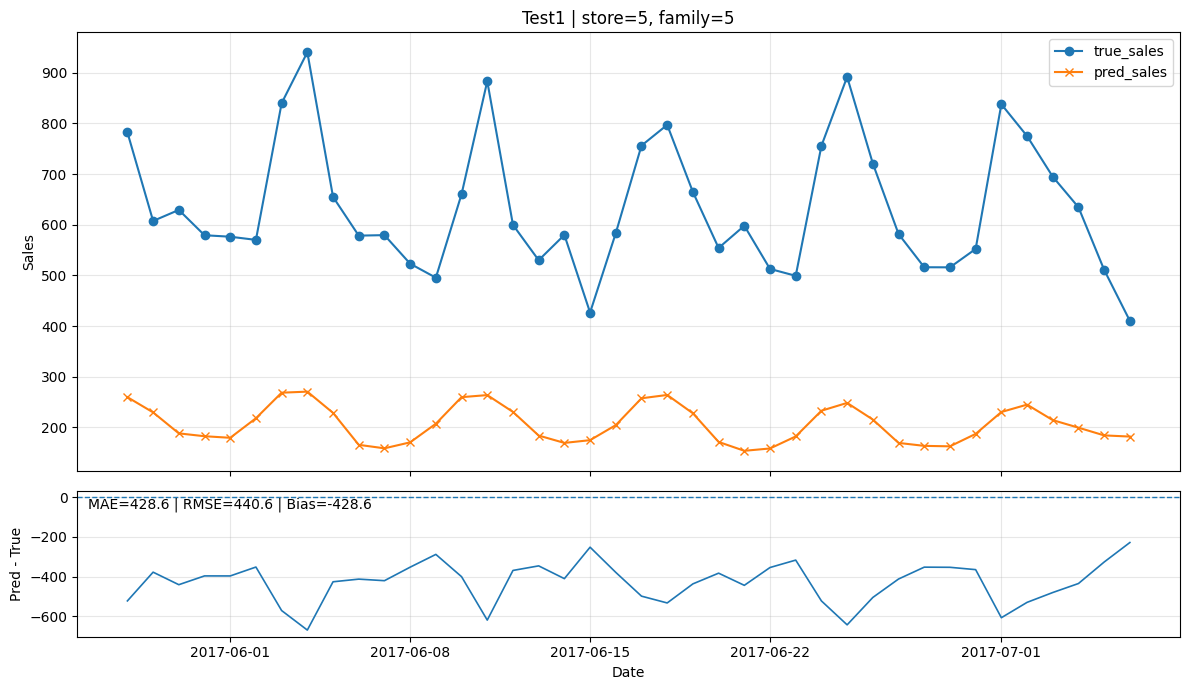

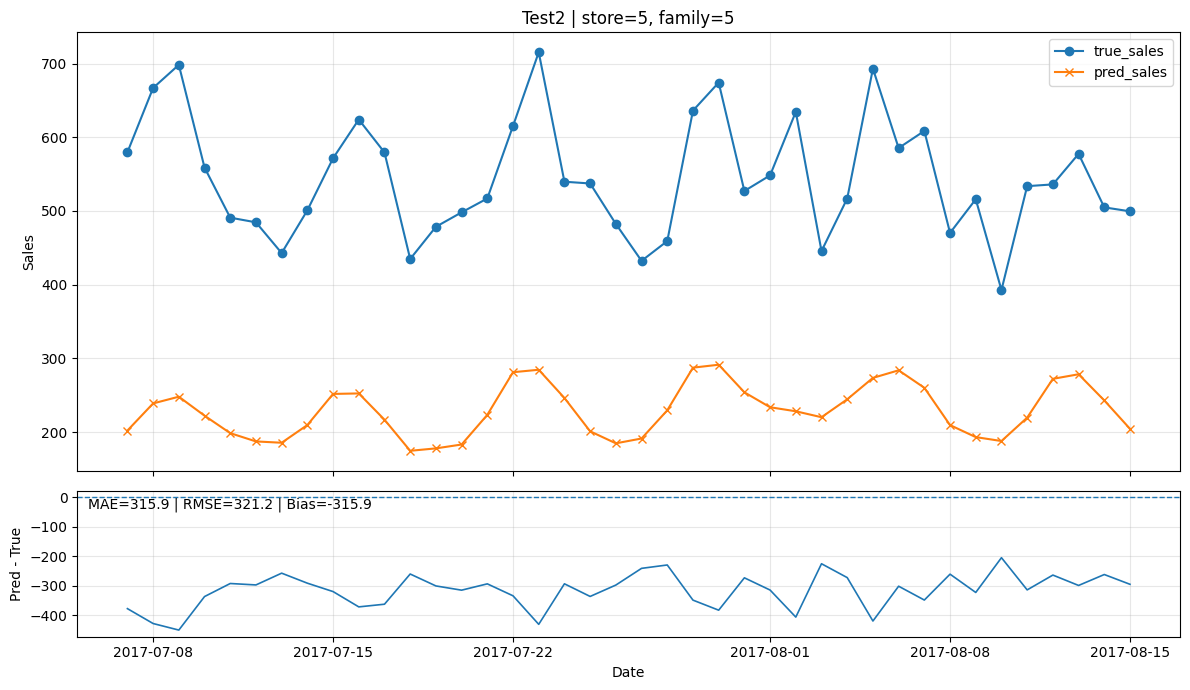

In [82]:
plot_series_compare(test1_tbl, store=5, family=5, title="Test1 | store=5, family=5")
plot_series_compare(test2_tbl, store=5, family=5, title="Test2 | store=5, family=5")

In [83]:
# Biểu đồ kiểm định lệch (calibration) và phân phối sai số
def plot_diagnostics(df, store, family, bins=30):
    d = (df[(df["store_nbr_idx"]==store) & (df["family_idx"]==family)]
           .sort_values("date").copy())
    if d.empty:
        print(f"No rows for store={store}, family={family}")
        return
    d["res"] = d["y_pred"] - d["y_true"]

    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    # Scatter true vs pred
    ax[0].scatter(d["y_true"], d["y_pred"], s=18, alpha=.7)
    lo = min(d["y_true"].min(), d["y_pred"].min())
    hi = max(d["y_true"].max(), d["y_pred"].max())
    ax[0].plot([lo,hi],[lo,hi], linestyle="--")
    ax[0].set_xlabel("True"); ax[0].set_ylabel("Pred"); ax[0].set_title("Calibration"); ax[0].grid(True, alpha=.3)

    # Histogram residuals
    ax[1].hist(d["res"], bins=bins, alpha=.9)
    ax[1].axvline(0, linestyle="--")
    ax[1].set_title("Residuals (Pred−True)")
    ax[1].set_xlabel("Error"); ax[1].set_ylabel("Freq")
    plt.tight_layout(); plt.show()

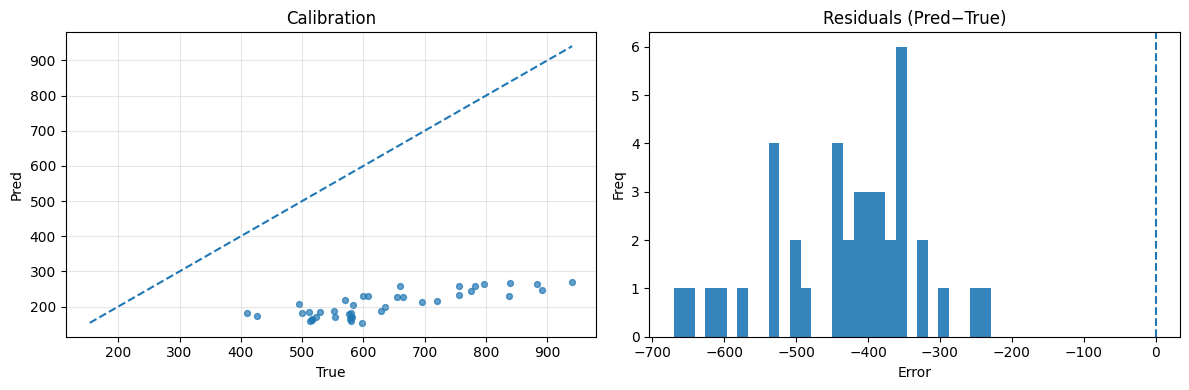

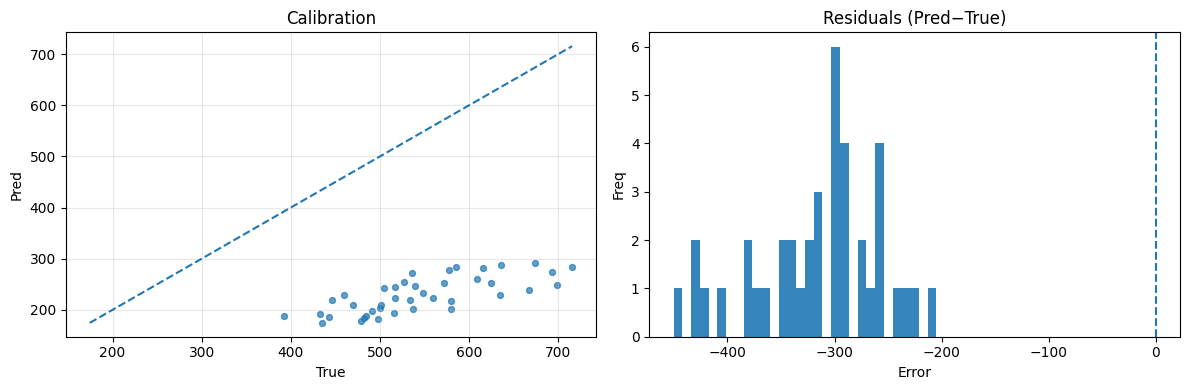

In [84]:
plot_diagnostics(test1_tbl, store=5, family=5)
plot_diagnostics(test2_tbl, store=5, family=5)


In [85]:
# 3) Tổng hợp nhanh theo series (xem series nào lệch nhất)
def summarize_by_series(df):
    g = df.copy()
    g["res"] = g["y_pred"] - g["y_true"]
    out = (g.groupby(["store_nbr_idx","family_idx"])
             .agg(MAE=("res", lambda r: np.mean(np.abs(r))),
                  RMSE=("res", lambda r: np.sqrt(np.mean(r**2))),
                  Bias=("res", "mean"),
                  N=("res", "size"))
             .reset_index()
             .sort_values("MAE", ascending=False))
    return out

summary1 = summarize_by_series(test1_tbl)
summary2 = summarize_by_series(test2_tbl)
print(summary1.head(10))
print(summary2.head(10))

      store_nbr_idx  family_idx           MAE          RMSE          Bias   N
1464             44          12  11477.546875  12022.861328 -11477.546875  40
1530             46          12  10808.974609  11311.767578 -10808.974609  40
1497             45          12  10591.294922  11417.951172 -10591.294922  40
1431             43          12  10243.661133  10716.223633 -10243.661133  40
1422             43           3  10152.251953  10835.975586 -10152.250977  40
1455             44           3   9639.130859  10310.681641  -9639.130859  40
1449             43          30   9594.998047   9962.993164  -9594.998047  40
1521             46           3   9055.590820   9771.858398  -9055.590820  40
69                2           3   8882.861328   9290.216797  -8882.861328  40
1563             47          12   8490.007812   9285.206055  -8490.007812  40
      store_nbr_idx  family_idx           MAE          RMSE          Bias   N
1464             44          12  10564.916992  10823.375977 -105